In [1]:

from matplotlib.colors import LinearSegmentedColormap
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import PolyCollection
from scipy.interpolate import griddata
from scipy.spatial import KDTree
from matplotlib.colors import ListedColormap
import matplotlib.patches as Patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr
import cmocean.cm as cmo 
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib as mpl
from scipy.spatial import Delaunay
#from Utiles import area_weighted_average, calculate_area_percentages

# Data

In [3]:
u = 0
tfs = 20 
afs = 18 
tifs = 15 
cbfs = 18
ctfs = 15

radius = 750000

n = 800000
m = n + 100000

colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 0.8, 
}

In [8]:
path1 ='../../../automated_testing/integrated_tests/idealised/Thule/results_test_killfront/'
path2 ='../../../automated_testing/integrated_tests/idealised/Thule/results_kill_all_350/'
path3 = '../../../automated_testing/integrated_tests/idealised/Thule/results_test_masks_kill/'
path4 = '../../../automated_testing/integrated_tests/idealised/Thule/results_explicit_kill/'
path5 = '../../../results_20251016_002/'
path6 = '../../../results_20251106_013/'

In [9]:
i = 1
Quad = xr.open_dataset(path6 + f'main_output_ANT_{i:05d}.nc')
Quad

<xarray.Dataset> Size: 53MB
Dimensions:                     (two: 2, vi: 26095, ci: 32, three: 3,
                                 ti: 51921, ei: 78015, four: 4, vori: 52192,
                                 bin: 11, time: 1, zeta: 12, month: 12,
                                 depth: 16)
Coordinates:
  * time                        (time) float64 8B 0.0
  * zeta                        (zeta) float64 96B 0.0 0.09091 ... 0.9091 1.0
  * month                       (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                       (depth) float64 128B 0.0 100.0 ... 1.5e+03
Dimensions without coordinates: two, vi, ci, three, ti, ei, four, vori, bin
Data variables: (12/83)
    xmin                        float64 8B ...
    xmax                        float64 8B ...
    ymin                        float64 8B ...
    ymax                        float64 8B ...
    tol_dist                    float64 8B ...
    lambda_M                    float64 8B ...
    ...                          ...
    mask_margin                 (time, vi) int32 104kB ...
    mask_gl_gr                  (time, vi) int32 104kB ...
    mask_gl_fl                  (time, vi) int32 104kB ...
    mask_cf_gr                  (time, vi) int32 104kB ...
    mask_icefree_ocean          (time, vi) int32 104kB ...
    mask_floating_ice           (time, vi) int32 104kB ...
Attributes:
    git commit hash:  ac2e8461b39934a07ee4d246b47de4b95632a822 (with uncommit...

In [13]:
# Initialize lists for all variables
BMB_list = []
Hi_list = []
Hs_list = []
Hib_list = []
Hb_list = []
Va_list = []
V_list = []
Tria_list = []
Tri_list = []
triang_list = []
distances_list = []
mask_ocean_list = []
mask_cf_fl_list = []
mask_gr_list = []
time_stamps_list = []  # Number of time stamps
time_values_list = []  # Actual time values if they exist

# Load all 11 datasets
for i in range(1, 3):
    # Open the dataset
    Quad = xr.open_dataset(path6 + f'main_output_ANT_{i:05d}.nc')
    
    # Extract variables
    BMB = Quad['BMB']
    Hi = Quad['Hi']
    Hs = Quad['Hi']  # Note: same as Hi?
    Hib = Quad['Hib']
    Hb = Quad['Hb']
    Va = Quad['V']
    V = Va.T
    Tria = Quad['Tri'] - 1  
    Tri = Tria.T
    triang = tri.Triangulation(V[:, 0], V[:, 1], Tri)
    
    # Calculate distances and masks
    distances = np.sqrt(V[:, 0]**2 + V[:, 1]**2)
    mask_ocean = distances <= radius
    mask_cf_fl = Quad['mask_cf_fl']
    mask_gr = Quad['mask_grounded_ice']
    
    # Get time information
    num_time_stamps = Hi.shape[0] if len(Hi.shape) > 1 else 1
    
    # Try to get actual time values if they exist in the dataset
    if 'time' in Quad.variables:
        time_values = Quad['time'].values
    else:
        time_values = None
    
    # Store in lists
    BMB_list.append(BMB)
    Hi_list.append(Hi)
    Hs_list.append(Hs)
    Hib_list.append(Hib)
    Hb_list.append(Hb)
    Va_list.append(Va)
    V_list.append(V)
    Tria_list.append(Tria)
    Tri_list.append(Tri)
    triang_list.append(triang)
    distances_list.append(distances)
    mask_ocean_list.append(mask_ocean)
    mask_cf_fl_list.append(mask_cf_fl)
    time_stamps_list.append(num_time_stamps)
    time_values_list.append(time_values)
    mask_gr_list.append(mask_gr)
    
    print(f"Loaded dataset {i}/11 - Time stamps: {num_time_stamps}")


# Print detailed summary
print("\nDetailed time stamps summary:")
for i, (num_ts, time_vals) in enumerate(zip(time_stamps_list, time_values_list), 1):
    if time_vals is not None:
        print(f"Dataset {i}: {num_ts} time stamps, time range: {time_vals[0]:.1f} to {time_vals[-1]:.1f} years")
    else:
        print(f"Dataset {i}: {num_ts} time stamps, no time coordinate")

Loaded dataset 1/11 - Time stamps: 1
Loaded dataset 2/11 - Time stamps: 100

Detailed time stamps summary:
Dataset 1: 1 time stamps, time range: 0.0 to 0.0 years
Dataset 2: 100 time stamps, time range: 0.1 to 10.0 years


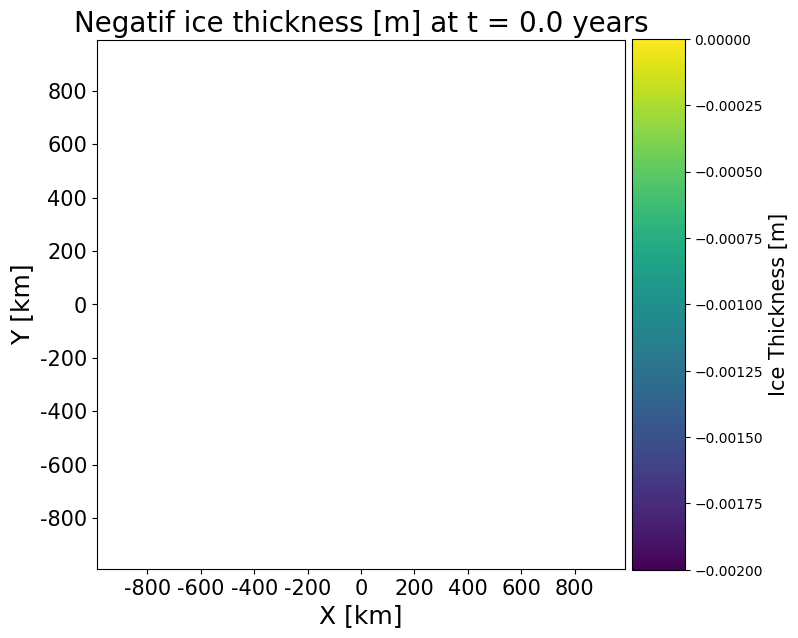

In [25]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.70, 
}
h = 1
m = 5
tim = 0.0

##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang_list[h], Hi_list[h][m].where(Hi_list[h][m] <0), vmin =-0.002, vmax =0)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Ice Thickness [m]", fontsize= ctfs) 
ax.set_title(f'Negatif ice thickness [m] at t = {tim} years', fontsize= tfs)

ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)

ax.set_aspect('equal')
#plt.savefig(f'../../../../{tim}.png', dpi=300)
plt.tight_layout()
plt.show()


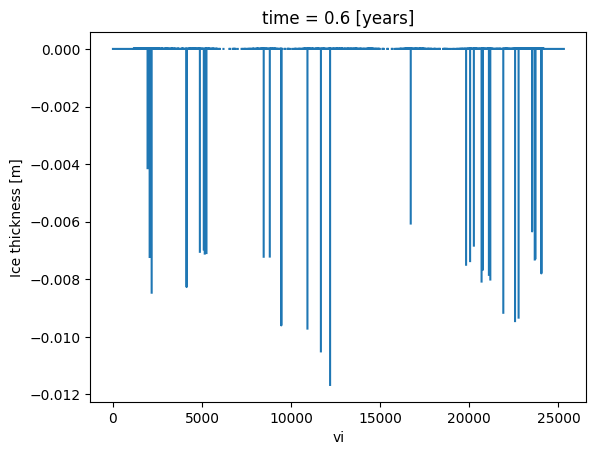

In [26]:
Hi_list[h][m].where(Hi_list[h][m] <= 0.0).plot()
#plt.title(f'Negatif ice thickness values at t = {tim} years')
plt.savefig(f'../../../../{tim}bis.png', dpi=300)


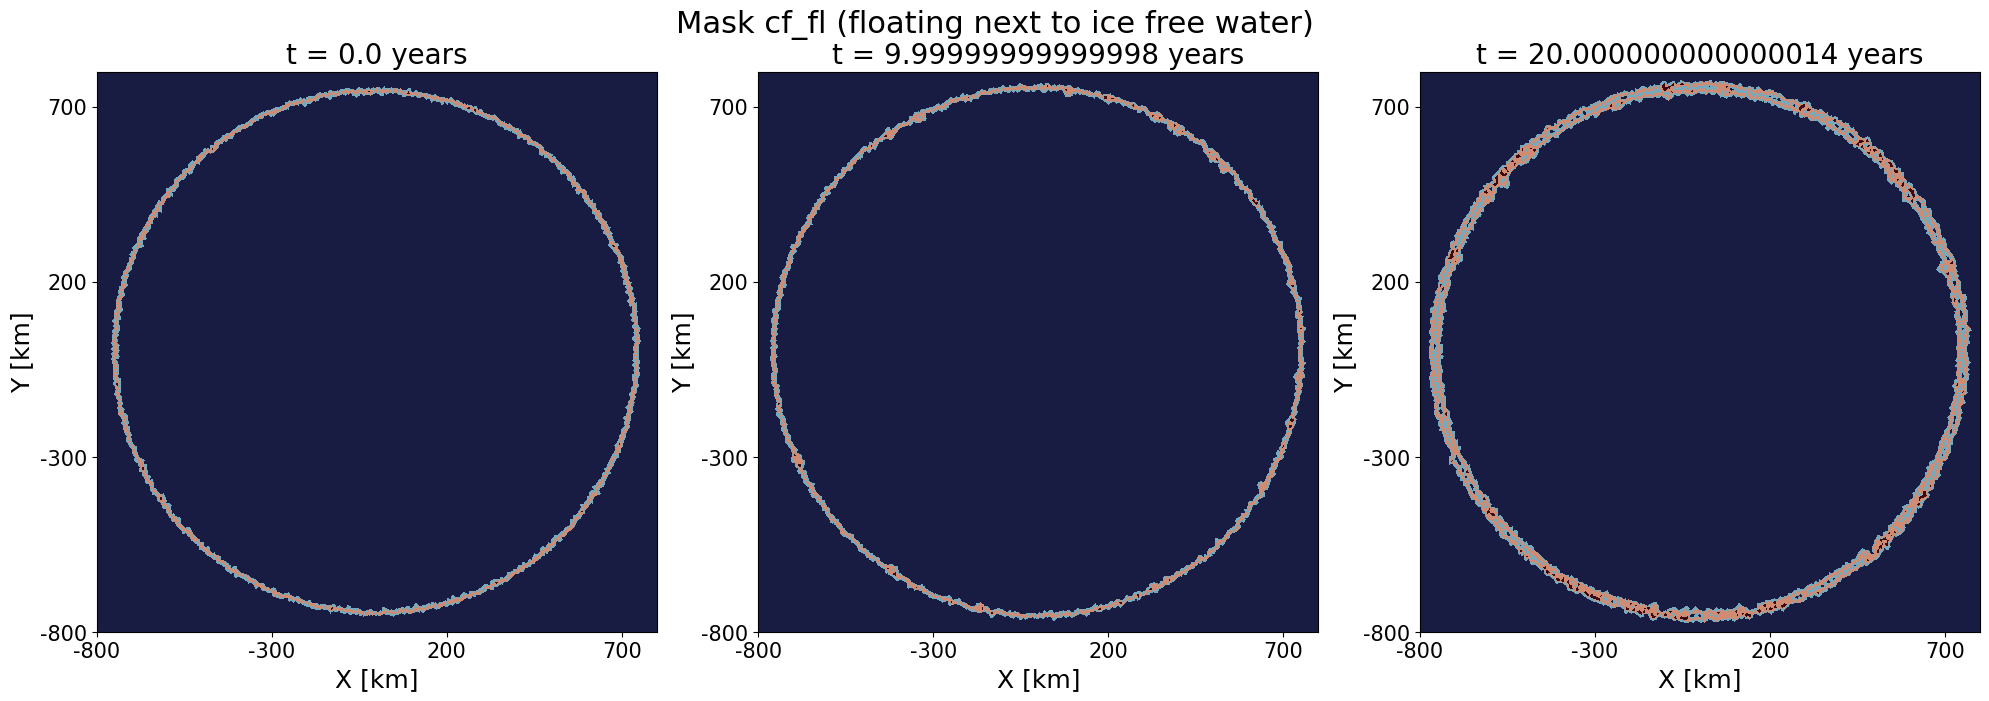

In [85]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 3, figsize=(20,8))

c0 = ax[0].tripcolor(triang_list[0], mask_cf_fl_list[0][0], cmap=cmo.balance)
c1 = ax[1].tripcolor(triang_list[1],  mask_cf_fl_list[1][-1], cmap=cmo.balance)
c2 = ax[2].tripcolor(triang_list[2],  mask_cf_fl_list[2][-1], cmap=cmo.balance)

ax[0].set_title(f't = {Hi_list[0][0].time.values} years', fontsize=tfs)
ax[1].set_title(f't = {Hi_list[1][-1].time.values} years', fontsize=tfs)
ax[2].set_title(f't = {Hi_list[2][-1].time.values} years', fontsize=tfs)

for i in range(3):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 500000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 500000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')
        #ax[j,i].set_title(f't = {years[j]+0.6*i:.1f} years', fontsize=tfs)

# Single colorbar for both plots
plt.suptitle('Mask cf_fl (floating next to ice free water)', fontsize=tfs+2, y=0.9)
"""cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)"""
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_77504/4044189267.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


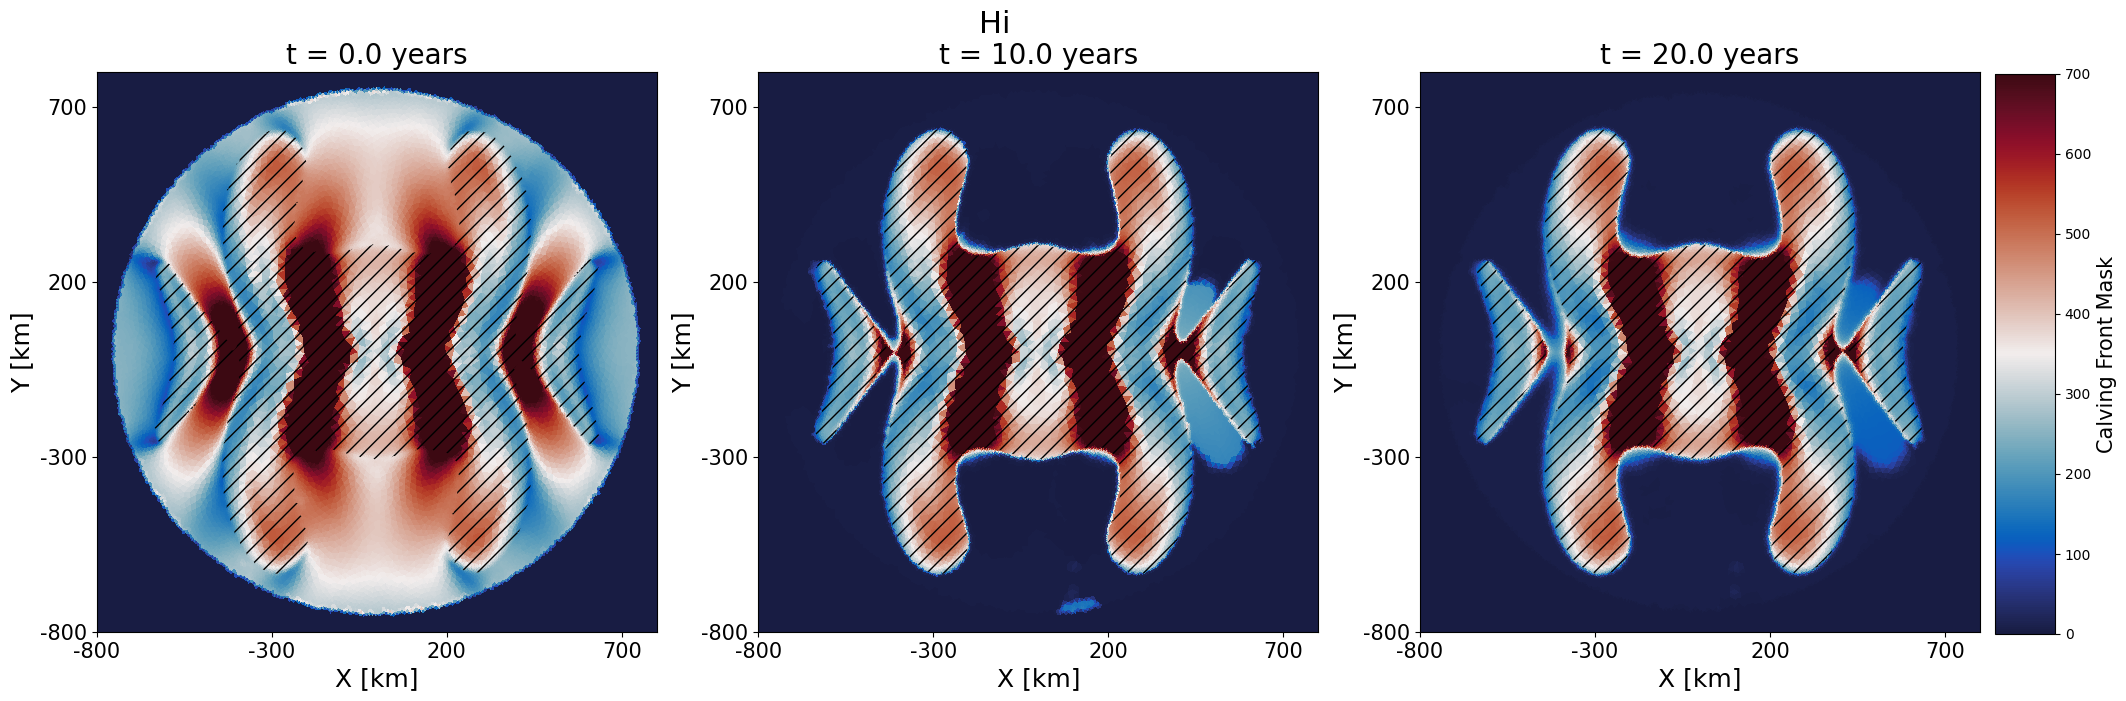

In [86]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 3, figsize=(20,8))

c0 = ax[0].tripcolor(triang_list[0], Hi_list[0][0], cmap=cmo.balance, vmin=0, vmax=700)
ax[0].tricontourf(triang_list[0], mask_gr_list[0][0].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['//'], alpha=0)
c1 = ax[1].tripcolor(triang_list[1],  Hi_list[1][-1], cmap=cmo.balance, vmin=0, vmax=700)
ax[1].tricontourf(triang_list[1], mask_gr_list[1][-1].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['//'], alpha=0)
c2 = ax[2].tripcolor(triang_list[2],  Hi_list[2][-1], cmap=cmo.balance, vmin=0, vmax=700)
ax[2].tricontourf(triang_list[2], mask_gr_list[2][-1].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['//'], alpha=0)

ax[0].set_title(f't = {Hi_list[0][0].time.values:.1f} years', fontsize=tfs)
ax[1].set_title(f't = {Hi_list[1][-1].time.values:.1f} years', fontsize=tfs)
ax[2].set_title(f't = {Hi_list[2][-1].time.values:.1f} years', fontsize=tfs)

for i in range(3):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 500000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 500000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')
        #ax[j,i].set_title(f't = {years[j]+0.6*i:.1f} years', fontsize=tfs)

# Single colorbar for both plots
plt.suptitle('Hi', fontsize=tfs+2, y=0.9)
cbar_ax = fig.add_axes([1, 0.12, 0.03, 0.70])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_77504/3950659196.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


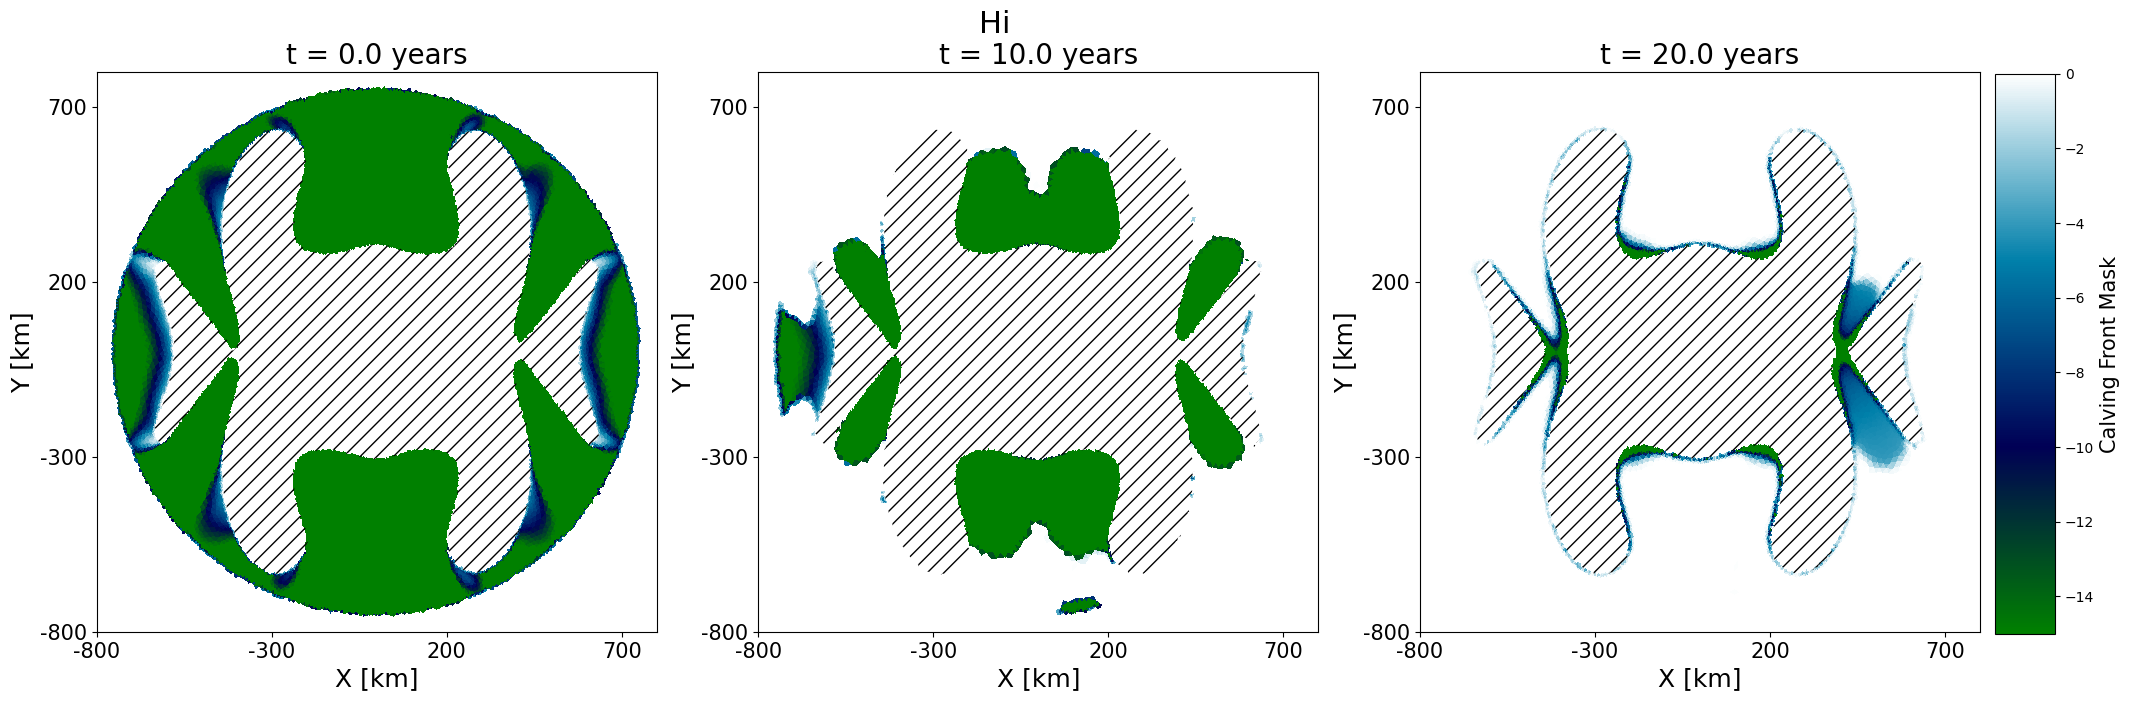

In [82]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 3, figsize=(20,8))

c0 = ax[0].tripcolor(triang_list[0], BMB_list[0][0], cmap='ocean', vmin=-15, vmax=0)
ax[0].tricontourf(triang_list[0], mask_gr_list[0][0].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['//'], alpha=0)
c1 = ax[1].tripcolor(triang_list[1],  BMB_list[1][19], cmap='ocean', vmin=-15, vmax=0)
ax[1].tricontourf(triang_list[1], mask_gr_list[1][19].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['//'], alpha=0)
c2 = ax[2].tripcolor(triang_list[2],  BMB_list[2][-1], cmap='ocean', vmin=-15, vmax=0)
ax[2].tricontourf(triang_list[2], mask_gr_list[2][-1].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['//'], alpha=0)

ax[0].set_title(f't = {Hi_list[0][0].time.values:.1f} years', fontsize=tfs)
ax[1].set_title(f't = {Hi_list[1][-1].time.values:.1f} years', fontsize=tfs)
ax[2].set_title(f't = {Hi_list[2][-1].time.values:.1f} years', fontsize=tfs)

for i in range(3):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 500000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 500000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')
        #ax[j,i].set_title(f't = {years[j]+0.6*i:.1f} years', fontsize=tfs)

# Single colorbar for both plots
plt.suptitle('Hi', fontsize=tfs+2, y=0.9)
cbar_ax = fig.add_axes([1, 0.12, 0.03, 0.70])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

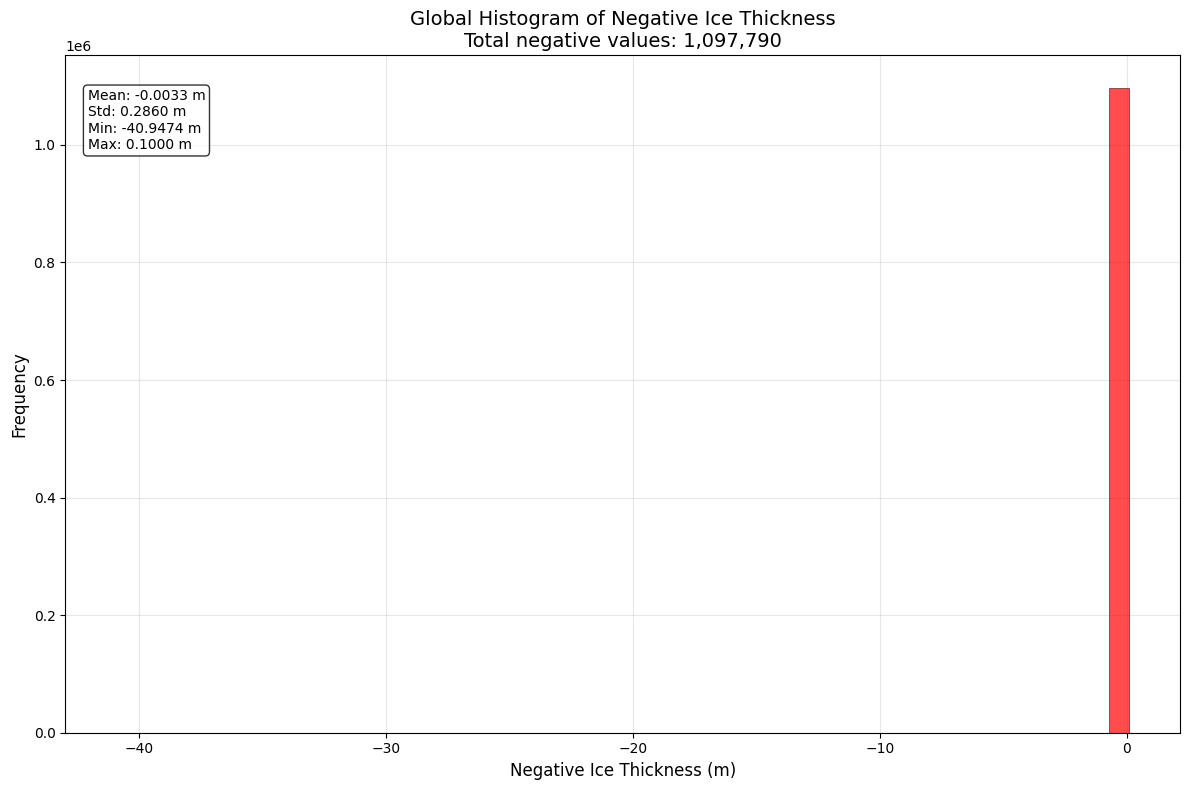

Global Negative Ice Thickness Statistics:
Total negative values: 1,097,790
Mean: -0.003345 m
Standard deviation: 0.285961 m
Minimum: -40.947400 m
Maximum: 0.099985 m
Range: 41.047385 m


In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Collect negative thickness values from ALL Hi_lists and ALL timestamps
all_negative_thickness = []

# Loop through all Hi_lists
for hi_lists in Hi_list:  # Assuming Hi_lists is your collection of lists
    # Loop through all timestamps in each Hi_list
    for timestamp_data in Hi_list:
        # Extract negative values using your method
        negative_values = timestamp_data.where(timestamp_data < 0.1).values.flatten()
        # Remove NaN values that might come from .where()
        negative_values = negative_values[~np.isnan(negative_values)]
        all_negative_thickness.extend(negative_values)

# Convert to numpy array
all_negative_thickness = np.array(all_negative_thickness)

# If no negative values found
if len(all_negative_thickness) == 0:
    print("No negative ice thickness values found across all Hi_lists!")
else:
    # Create the histogram
    plt.figure(figsize=(12, 8))

    # Plot histogram
    n, bins, patches = plt.hist(all_negative_thickness, bins=50, alpha=0.7, 
                                color='red', edgecolor='black', linewidth=0.5)

    # Customize the plot
    plt.xlabel('Negative Ice Thickness (m)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Global Histogram of Negative Ice Thickness\n'
              f'Total negative values: {len(all_negative_thickness):,}', fontsize=14)

    # Add statistics to the plot
    mean_val = np.mean(all_negative_thickness)
    std_val = np.std(all_negative_thickness)
    min_val = np.min(all_negative_thickness)
    max_val = np.max(all_negative_thickness)

    stats_text = f'Mean: {mean_val:.4f} m\nStd: {std_val:.4f} m\nMin: {min_val:.4f} m\nMax: {max_val:.4f} m'
    plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                fontsize=10, verticalalignment='top')

    # Add grid
    plt.grid(True, alpha=0.3)

    # Customize appearance
    plt.gca().set_axisbelow(True)

    # Save the figure
    plt.tight_layout()
    plt.savefig('global_negative_ice_thickness_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print(f"Global Negative Ice Thickness Statistics:")
    print(f"Total negative values: {len(all_negative_thickness):,}")
    print(f"Mean: {mean_val:.6f} m")
    print(f"Standard deviation: {std_val:.6f} m")
    print(f"Minimum: {min_val:.6f} m")
    print(f"Maximum: {max_val:.6f} m")
    print(f"Range: {max_val - min_val:.6f} m")

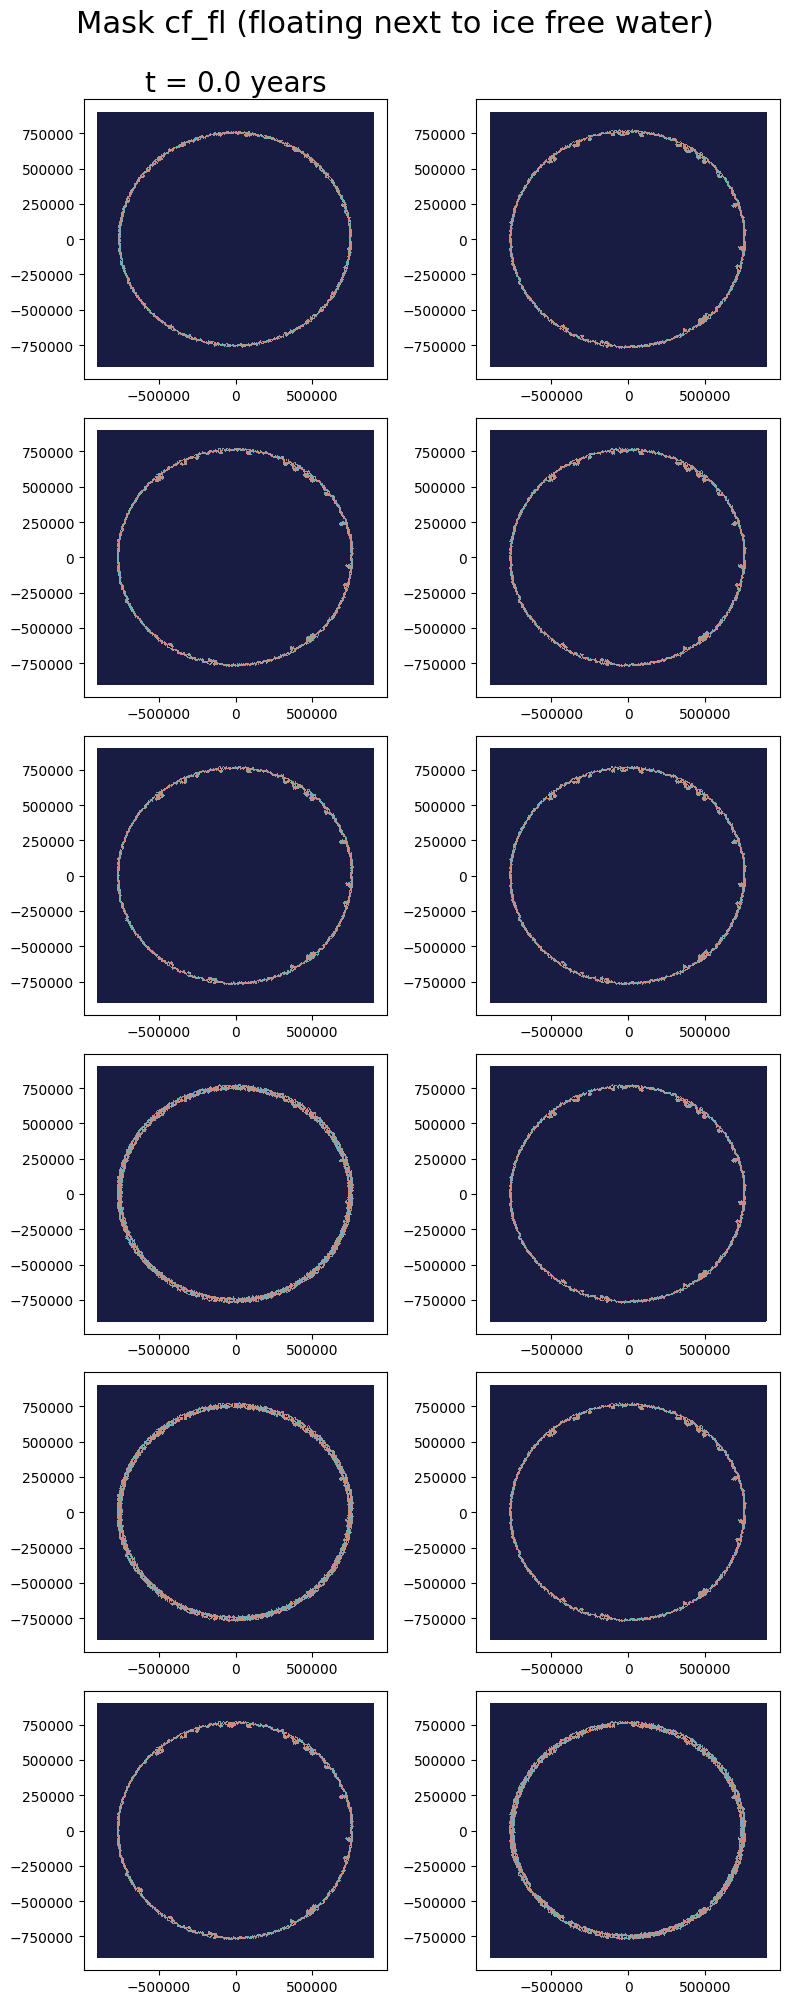

In [67]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(6, 2, figsize=(8,20))

c0 = ax[0,0].tripcolor(triang_list[1], mask_cf_fl_list[1][-1], cmap=cmo.balance)
ax[0,0].set_title('t = 0.0 years', fontsize=tfs)
for i in range(0,5):
    c0 = ax[i+1,0].tripcolor(triang_list[2],  mask_cf_fl_list[2][i], cmap=cmo.balance)
for i in range(6):
    c1 = ax[i,1].tripcolor(triang_list[2],  mask_cf_fl_list[2][i+5], cmap=cmo.balance)
    

'''

for j in range(6):
    for i in range(2):
        ax[j,i].set_xlabel('X [km]', fontsize=afs)
        ax[j,i].set_ylabel('Y [km]', fontsize=afs)
        ax[j,i].set_xticks(np.arange(-n, n + 1, 500000))
        ax[j,i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j,i].set_yticks(np.arange(-n, n + 1, 500000))
        ax[j,i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j,i].set_xlim(-n, n)
        ax[j,i].set_ylim(-n, n)
        ax[j,i].set_aspect('equal')
        #ax[j,i].set_title(f't = {years[j]+0.6*i:.1f} years', fontsize=tfs)
'''
# Single colorbar for both plots
plt.suptitle('Mask cf_fl (floating next to ice free water)', fontsize=tfs+2, y=1.0)
"""cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)"""
plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

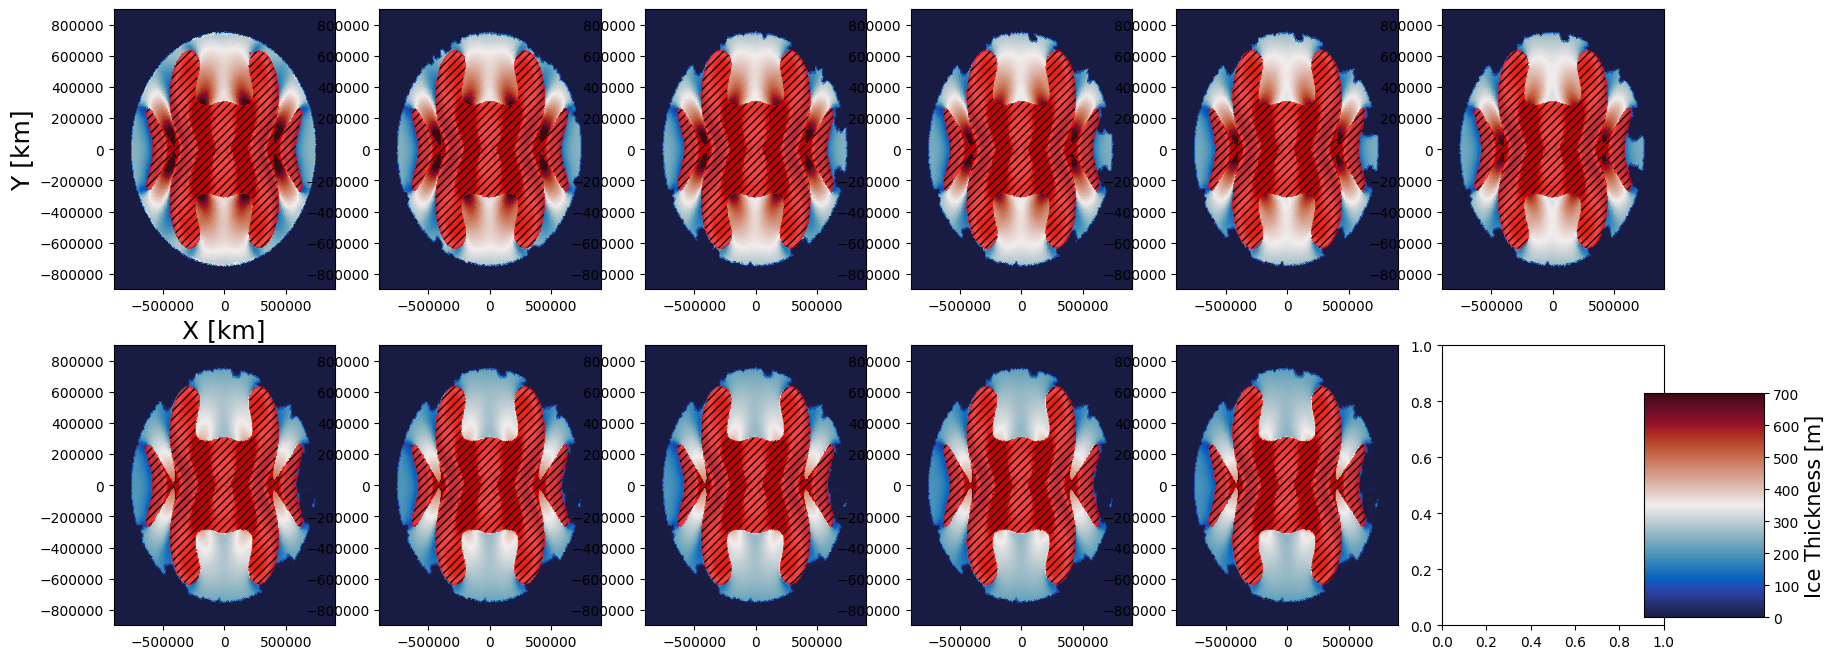

In [68]:
import matplotlib.gridspec as gridspec

colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}
years = np.arange(0.0,1.1,0.1)
##############################################################################################################################
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(2, 6)  # Only 6 columns

ax = [[plt.subplot(gs[0, i]) for i in range(6)],
      [plt.subplot(gs[1, i]) for i in range(6)]]

# Your plotting code...
c0 = ax[0][0].tripcolor(triang_list[0], Hi_list[0][0], cmap=cmo.balance, vmin=0, vmax=700)
ax[0][0].tricontourf(triang_list[0], mask_gr_list[0][0].astype(float), levels=[0.5, 1.5], 
                   colors='red', hatches=['////'], alpha=0.7)

for i in range(0,5):
    c0 = ax[0][i+1].tripcolor(triang_list[1], Hi_list[1][i], cmap=cmo.balance, vmin=0, vmax=700)
    ax[0][i+1].tricontourf(triang_list[1], mask_gr_list[1][i].astype(float), levels=[0.5, 1.5], 
                         colors='red', hatches=['////'], alpha=0.7)

for i in range(5):
    c1 = ax[1][i].tripcolor(triang_list[1], Hi_list[1][i+15], cmap=cmo.balance, vmin=0, vmax=700)
    ax[1][i].tricontourf(triang_list[1], mask_gr_list[1][i+15].astype(float), levels=[0.5, 1.5], 
                       colors='red', hatches=['////'], alpha=0.7)

# Add colorbar manually to the right of the plots
plt.subplots_adjust(right=0.9)  # Make space on the right
cbar_ax = fig.add_axes([0.89, 0.12, 0.06, 0.28])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Ice Thickness [m]", fontsize=ctfs)

for j in range(2):
    for i in range(6):
        ax[j][i].set_xlabel('X [km]', fontsize=afs)
        ax[j][i].set_ylabel('Y [km]', fontsize=afs)
        ax[j][i].set_xticks(np.arange(-n, n + 1, 500000))
        ax[j][i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j][i].set_yticks(np.arange(-n, n + 1, 500000))
        ax[j][i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j][i].set_xlim(-n, n)
        ax[j][i].set_ylim(-n, n)
        ax[j][i].set_aspect('equal')
        if (j == 0 and i < 6) or (j == 1 and i < 5):
            ax[j][i].set_title(f't = {years[j*6+i]:.1f} years', fontsize=tfs)
        else:
            break

plt.suptitle('Ice thickness (grounded part hatched)', fontsize=tfs+2, y=1.0)
plt.tight_layout()
plt.show()

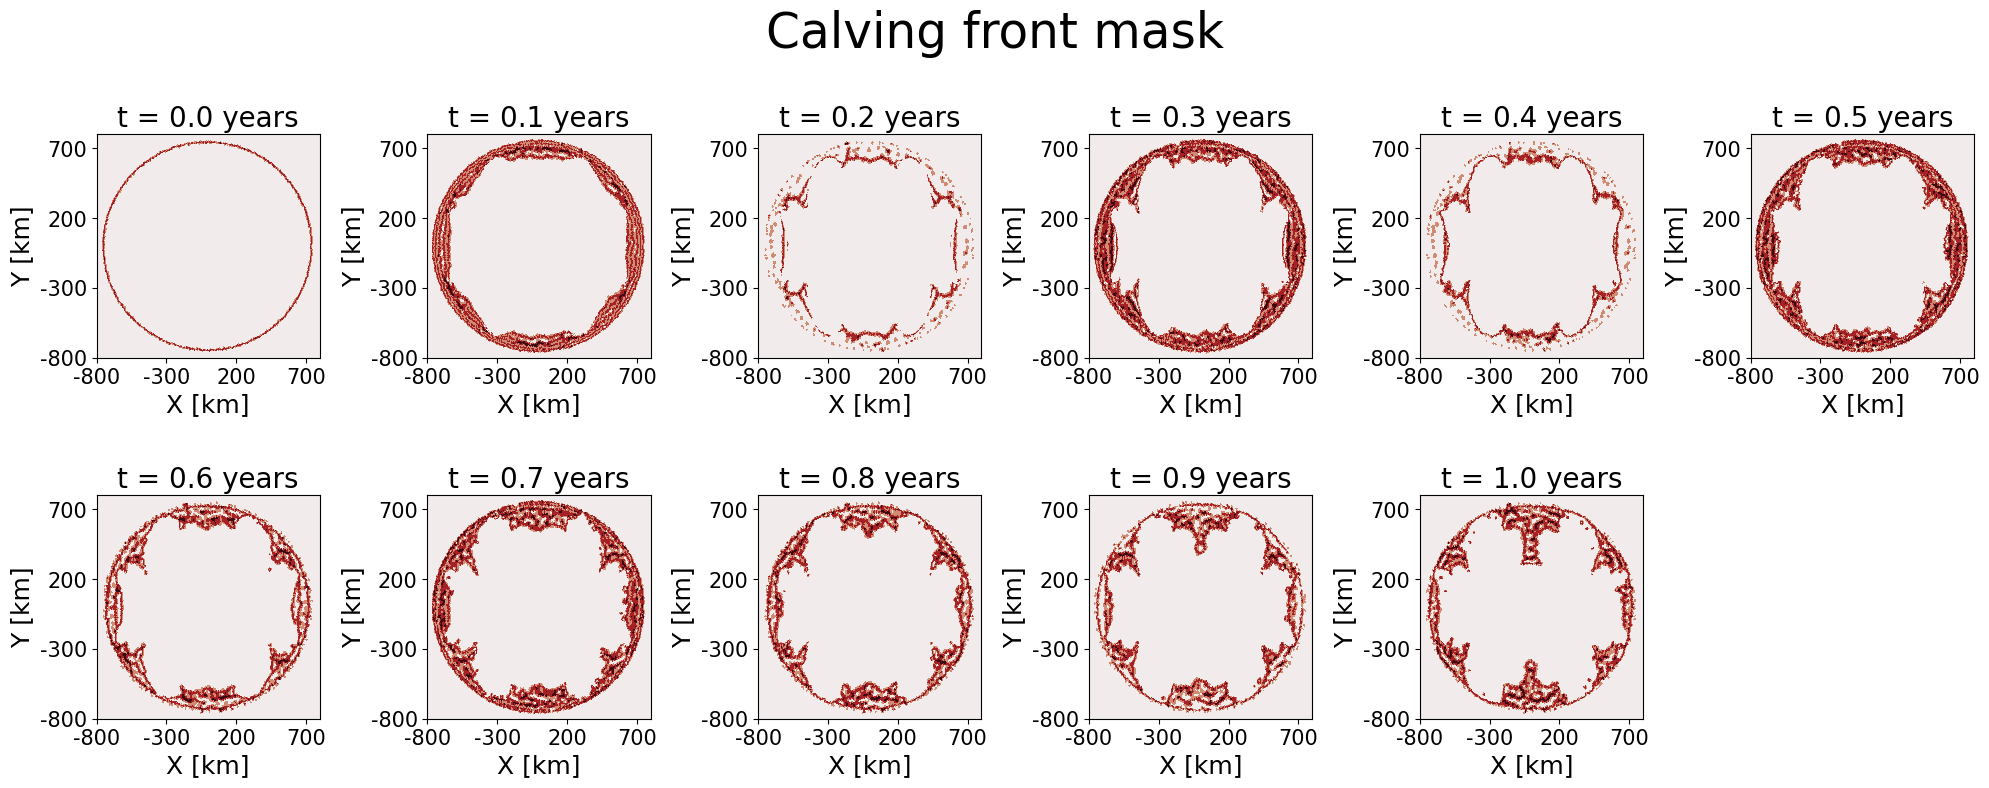

In [ ]:
import matplotlib.gridspec as gridspec

colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(2, 6)  # Only 6 columns

ax = [[plt.subplot(gs[0, i]) for i in range(6)],
      [plt.subplot(gs[1, i]) for i in range(6)]]

# Your plotting code...
c0 = ax[0][0].tripcolor(triang1t, mask_cf1[0], cmap=cmo.balance, vmin=-1, vmax=1)


for i in range(0,5):
    c0 = ax[0][i+1].tripcolor(triang2t, mask_cf2[i], cmap=cmo.balance, vmin=-1, vmax=1)


for i in range(5):
    c1 = ax[1][i].tripcolor(triang2t, mask_cf2[i+5], cmap=cmo.balance, vmin=-1, vmax=1)

# REMOVE THE EMPTY SUBPLOT IN ROW 2, COLUMN 6
ax[1][5].remove()

for j in range(2):
    for i in range(6):
        if j == 1 and i == 5:
            continue  # Skip the removed subplot
        ax[j][i].set_xlabel('X [km]', fontsize=afs)
        ax[j][i].set_ylabel('Y [km]', fontsize=afs)
        ax[j][i].set_xticks(np.arange(-n, n + 1, 500000))
        ax[j][i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j][i].set_yticks(np.arange(-n, n + 1, 500000))
        ax[j][i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j][i].set_xlim(-n, n)
        ax[j][i].set_ylim(-n, n)
        ax[j][i].set_aspect('equal')
        ax[j][i].set_title(f't = {years[j*6+i]:.1f} years', fontsize=tfs)

plt.suptitle('Calving front mask', fontsize=tfs+15, y=1.0)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_34044/3641340062.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


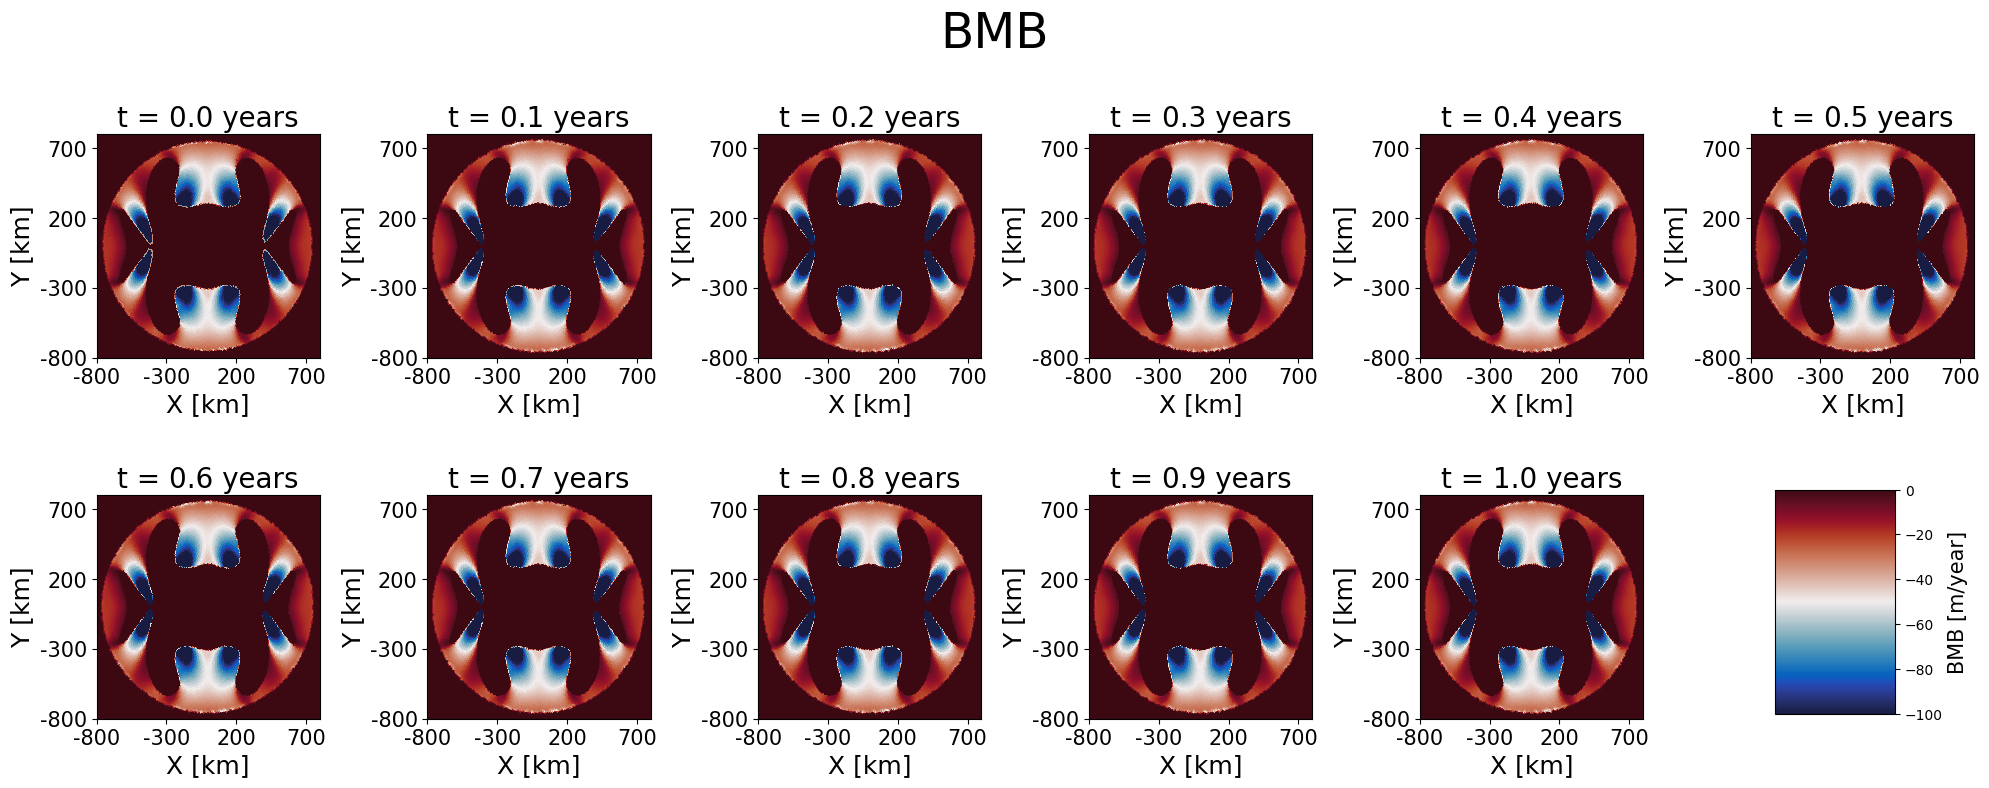

In [ ]:
import matplotlib.gridspec as gridspec

colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(2, 6)  # Only 6 columns

ax = [[plt.subplot(gs[0, i]) for i in range(6)],
      [plt.subplot(gs[1, i]) for i in range(6)]]

# Your plotting code...
c0 = ax[0][0].tripcolor(triang1t, BMB1t[0], cmap=cmo.balance, vmin=-100, vmax=0)

for i in range(0,5):
    c0 = ax[0][i+1].tripcolor(triang2t, BMB2t[i], cmap=cmo.balance, vmin=-100, vmax=0)

for i in range(5):
    c1 = ax[1][i].tripcolor(triang2t, BMB2t[i+5], cmap=cmo.balance, vmin=-100, vmax=0)

# REMOVE THE EMPTY SUBPLOT IN ROW 2, COLUMN 6
ax[1][5].remove()

# Add colorbar manually to the right of the plots
plt.subplots_adjust(right=0.9)  # Make space on the right
cbar_ax = fig.add_axes([0.89, 0.12, 0.06, 0.28])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("BMB [m/year]", fontsize=ctfs)

for j in range(2):
    for i in range(6):
        if j == 1 and i == 5:
            continue  # Skip the removed subplot
        ax[j][i].set_xlabel('X [km]', fontsize=afs)
        ax[j][i].set_ylabel('Y [km]', fontsize=afs)
        ax[j][i].set_xticks(np.arange(-n, n + 1, 500000))
        ax[j][i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j][i].set_yticks(np.arange(-n, n + 1, 500000))
        ax[j][i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j][i].set_xlim(-n, n)
        ax[j][i].set_ylim(-n, n)
        ax[j][i].set_aspect('equal')
        ax[j][i].set_title(f't = {years[j*6+i]:.1f} years', fontsize=tfs)

plt.suptitle('BMB', fontsize=tfs+15, y=1.0)
plt.tight_layout()
plt.show()

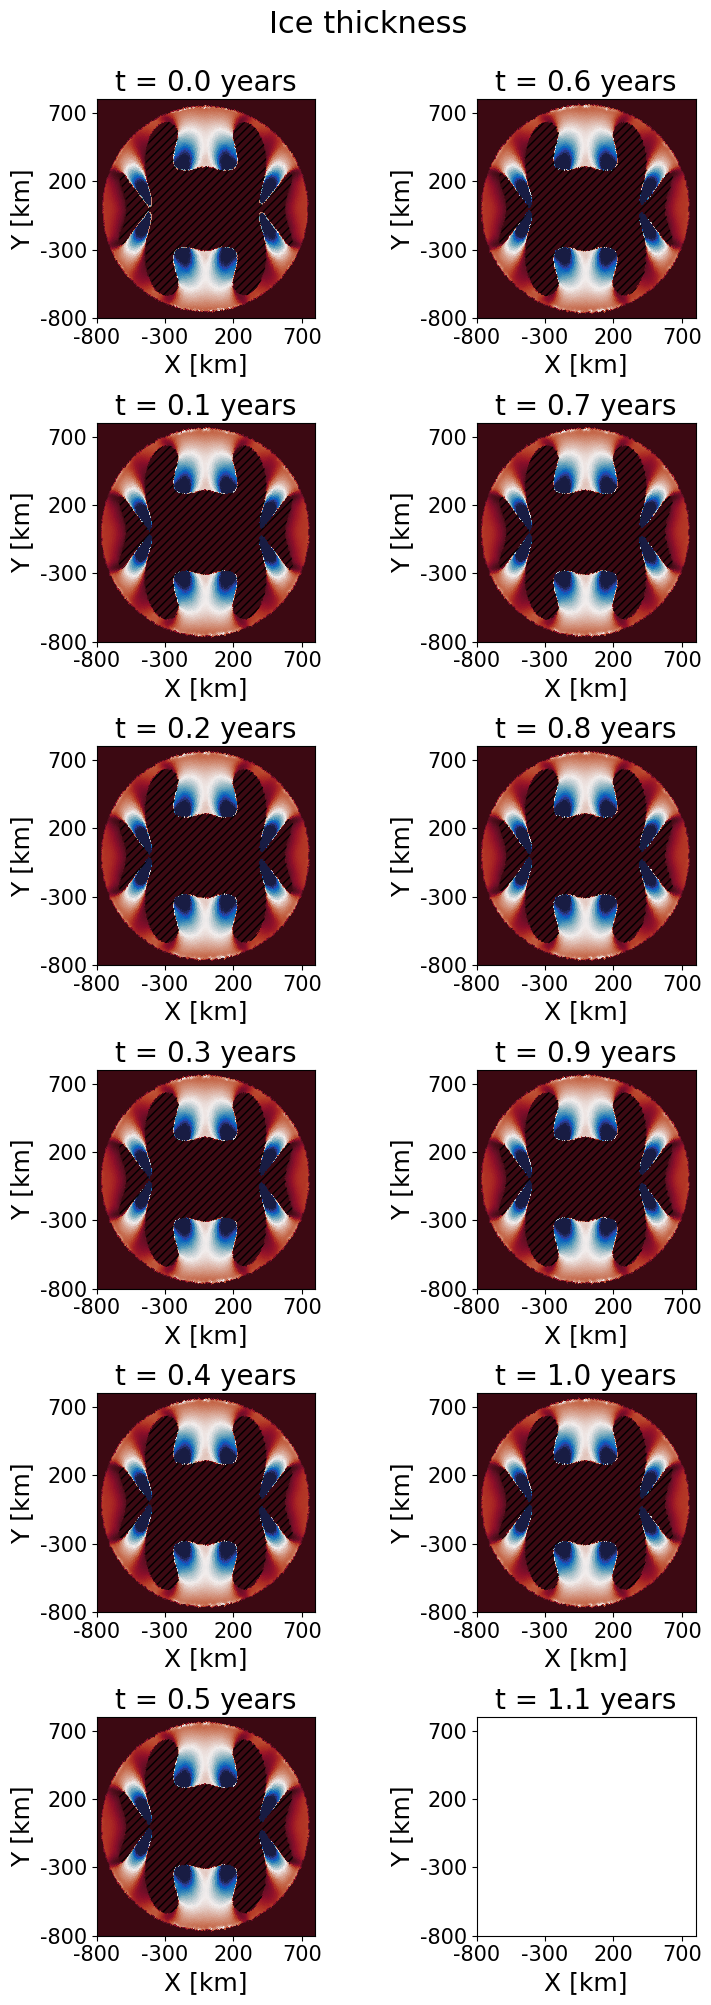

In [102]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(6, 2, figsize=(8,20))

c0 = ax[0,0].tripcolor(triang1t, BMB1t[0], cmap=cmo.balance, vmin = -100, vmax = 0)
ax[0,0].tricontourf(triang1t, mask_gr1t[0].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['////'], alpha=0)

for i in range(0,5):
    c0 = ax[i+1,0].tripcolor(triang2t, BMB2t[i], cmap=cmo.balance, vmin = -100, vmax = 0)
    ax[i+1,0].tricontourf(triang2t, mask_gr2t[i].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['////'], alpha=0)
for i in range(5):
    c1 = ax[i,1].tripcolor(triang2t, BMB2t[i+5], cmap=cmo.balance,  vmin = -100, vmax = 0)
    ax[i,1].tricontourf(triang2t, mask_gr2t[i+5].astype(float), levels=[0.5, 1.5], 
               colors='none', hatches=['////'], alpha=0)

for j in range(6):
    for i in range(2):
        ax[j,i].set_xlabel('X [km]', fontsize=afs)
        ax[j,i].set_ylabel('Y [km]', fontsize=afs)
        ax[j,i].set_xticks(np.arange(-n, n + 1, 500000))
        ax[j,i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j,i].set_yticks(np.arange(-n, n + 1, 500000))
        ax[j,i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 500), fontsize=tifs)
        ax[j,i].set_xlim(-n, n)
        ax[j,i].set_ylim(-n, n)
        ax[j,i].set_aspect('equal')
        ax[j,i].set_title(f't = {years[j]+0.6*i:.1f} years', fontsize=tfs)

# Single colorbar for both plots
plt.suptitle('Ice thickness', fontsize=tfs+2, y=1.0)
"""cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)"""
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Negatif ice thickness values at t = 0.1 years')

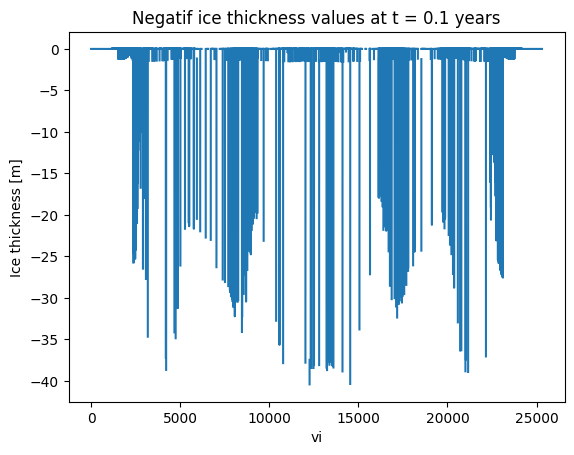

In [ ]:
Hi_list[9][0].where(Hi_list[9][0] <= 0.0).plot()
plt.title('Negatif ice thickness values at t = 0.1 years')


In [28]:
# Calculate percentage of negative values for a single dataset
def calculate_negative_percentage(Hi_data):
    Hi_values = Hi_data.values.flatten()  # Convert to 1D array
    total_vertices = len(Hi_values)
    negative_count = np.sum(Hi_values < 0)
    negative_percentage = (negative_count / total_vertices) * 100
    
    return negative_percentage, negative_count, total_vertices

# For a single dataset (e.g., first time step)
neg_percentage, neg_count, total_vertices = calculate_negative_percentage(Hi_list[0])
print(f"Dataset 1: {neg_percentage:.4f}% negative ({neg_count}/{total_vertices} vertices)")
neg = []
# Calculate for all 11 datasets
print("\nNegative ice thickness percentages for all datasets:")
for i, Hi_data in enumerate(Hi_list):
    for j in range (len(Hi_data)):
        print (j)
        neg_percentage, neg_count, total_vertices = calculate_negative_percentage(Hi_data[j])
        print(f"Dataset {i+1} time step {j}: {neg_percentage:.4f}% negative ({neg_count}/{total_vertices} vertices)")
        neg.append(neg_percentage)
neg = np.array(neg)

Dataset 1: 0.0000% negative (0/26095 vertices)

Negative ice thickness percentages for all datasets:
0
Dataset 1 time step 0: 0.0000% negative (0/26095 vertices)
0
Dataset 2 time step 0: 0.0000% negative (0/25307 vertices)
1
Dataset 2 time step 1: 0.1897% negative (48/25307 vertices)
2
Dataset 2 time step 2: 0.0000% negative (0/25307 vertices)
3
Dataset 2 time step 3: 0.1897% negative (48/25307 vertices)
4
Dataset 2 time step 4: 0.0000% negative (0/25307 vertices)
5
Dataset 2 time step 5: 0.1897% negative (48/25307 vertices)
6
Dataset 2 time step 6: 0.1897% negative (48/25307 vertices)
7
Dataset 2 time step 7: 0.0000% negative (0/25307 vertices)
8
Dataset 2 time step 8: 0.0000% negative (0/25307 vertices)
9
Dataset 2 time step 9: 0.1897% negative (48/25307 vertices)
10
Dataset 2 time step 10: 0.1897% negative (48/25307 vertices)
11
Dataset 2 time step 11: 0.0000% negative (0/25307 vertices)
12
Dataset 2 time step 12: 0.0000% negative (0/25307 vertices)
13
Dataset 2 time step 13: 0.0000

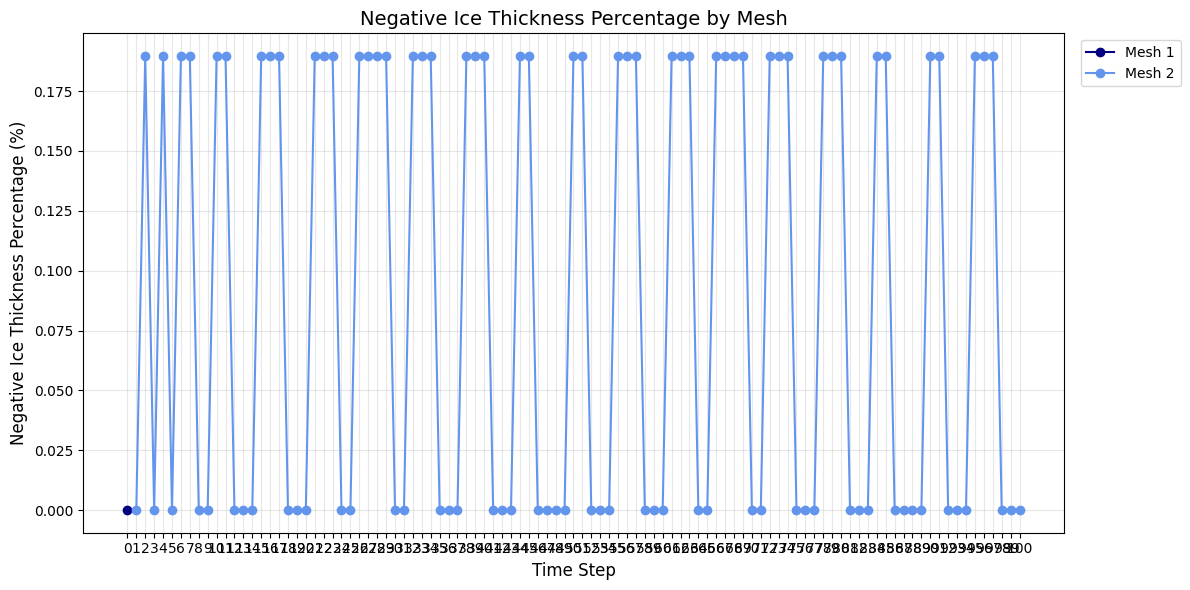

In [29]:
plt.figure(figsize=(12, 6))

# Create time axis based on your time steps
time_axis = range(len(neg))  # This assumes each index corresponds to a time step

# Plot for first mesh (time_stamps_list[0] time steps)
plt.plot(time_axis[:time_stamps_list[0]], neg[:time_stamps_list[0]], 
         marker='o', linestyle='-', color='navy', label='Mesh 1')

# Plot for second mesh
start_idx = time_stamps_list[0]
end_idx = time_stamps_list[0] + time_stamps_list[1]
plt.plot(time_axis[start_idx:end_idx], neg[start_idx:end_idx], 
         marker='o', linestyle='-', color='cornflowerblue', label='Mesh 2')

colors = ['firebrick', 'darkred','maroon']

start_idx = time_stamps_list[0] + time_stamps_list[1]
for i in range(2, len(time_stamps_list)):
    end_idx = start_idx + time_stamps_list[i]
    plt.plot(time_axis[start_idx:end_idx], neg[start_idx:end_idx], 
             marker='o', linestyle='-', color=colors[i-2], label=f'Mesh {i+1}')
    start_idx = end_idx
#plt.xlim(-1, 101)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Negative Ice Thickness Percentage (%)', fontsize=12)
plt.title('Negative Ice Thickness Percentage by Mesh', fontsize=14)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(time_axis)  # Show all time steps on x-axis
plt.tight_layout()
plt.show()

IndexError: list index out of range

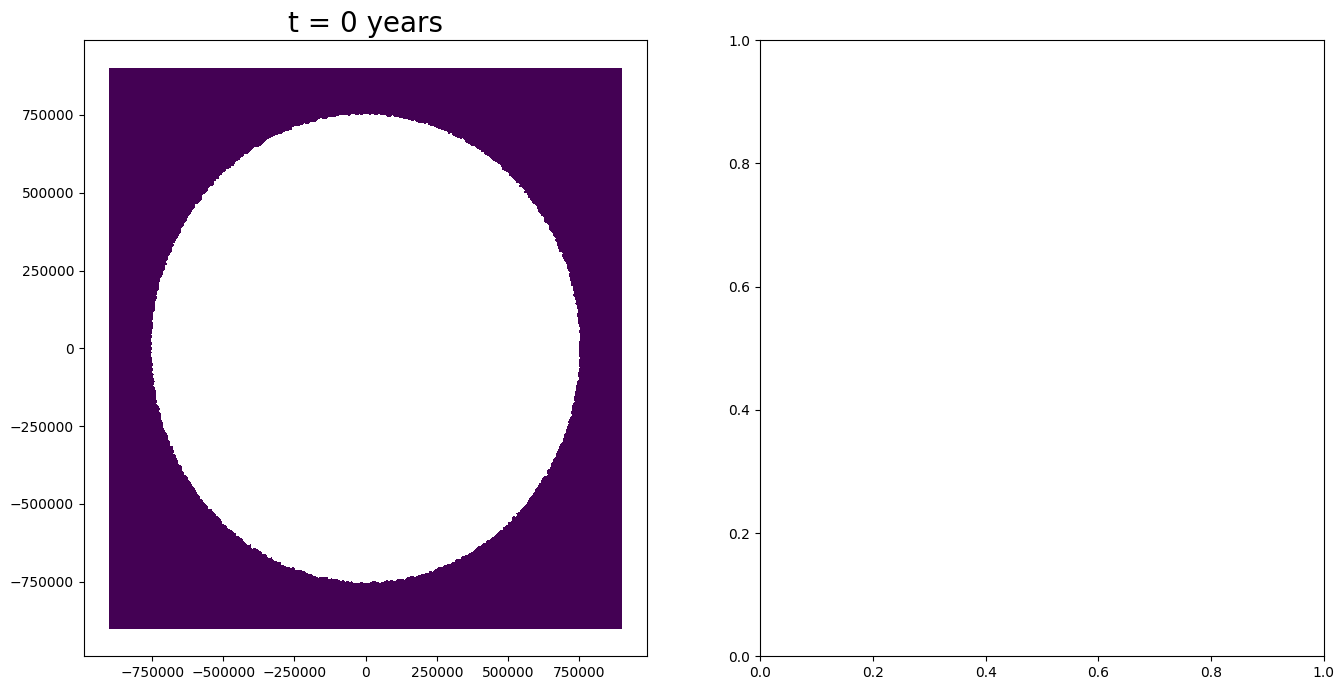

In [30]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang_list[0], Hi_list[0][0].where(Hi_list[0][0] == 0))
ax[0].set_title('t = 0 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang_list[2], Hi_list[2][0].where(Hi_list[2][0] <= 0.5))
ax[1].set_title('t = 0.5 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Mask margin (ice next to ice free)', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask (ice next to ice free)", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_34044/1338832662.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


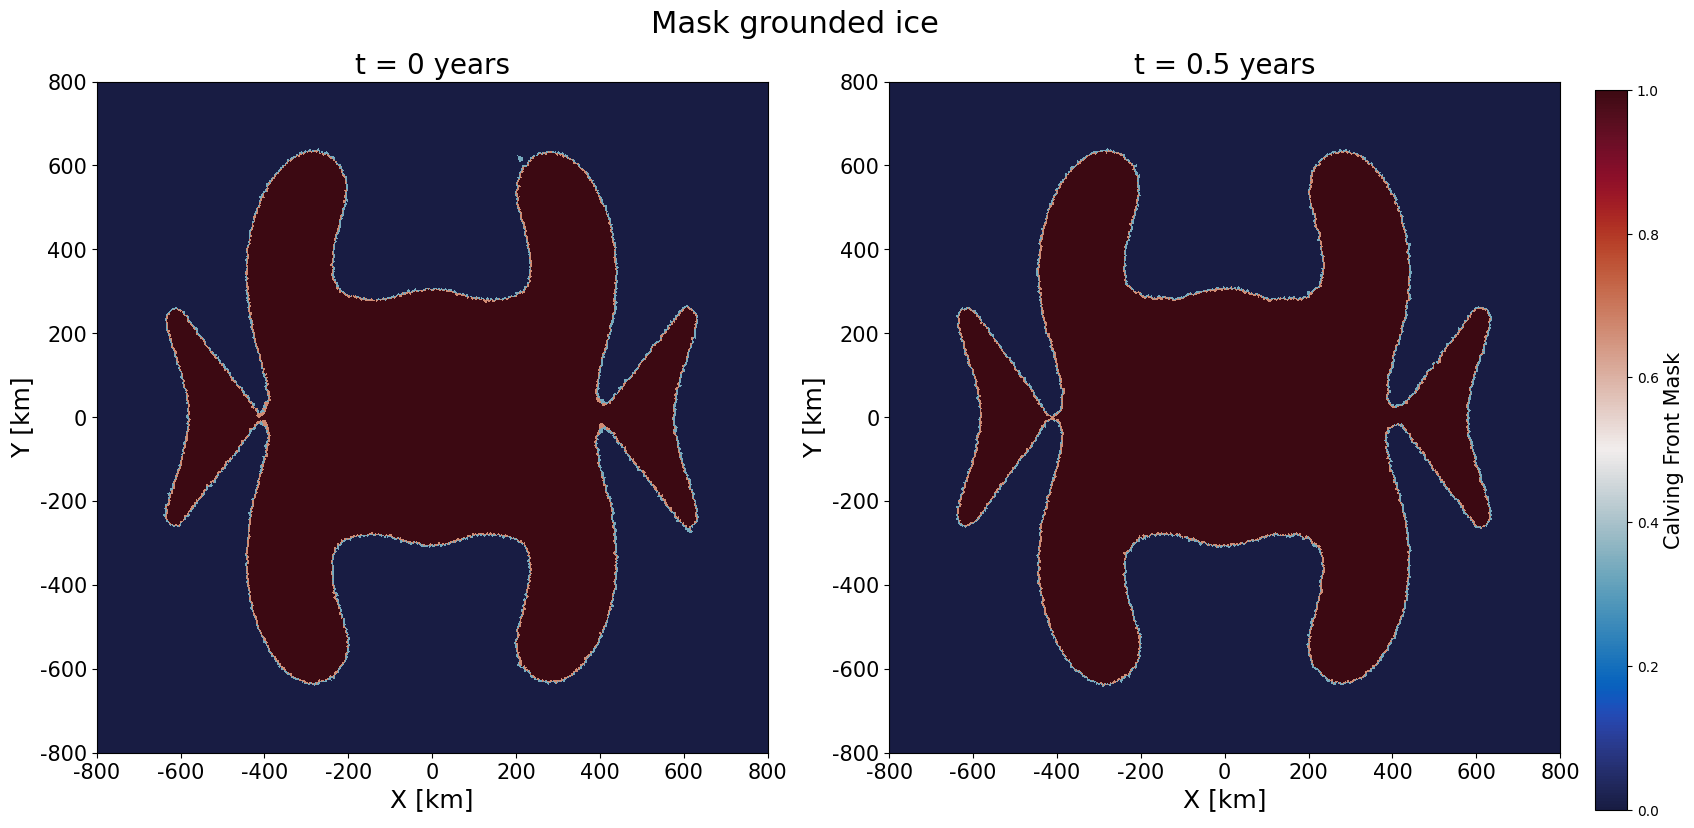

In [20]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang1t, mask_gr1[0], cmap=cmo.balance)
ax[0].set_title('t = 0 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang2t, mask_gr2[5], cmap=cmo.balance)
ax[1].set_title('t = 0.5 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Mask grounded ice', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_34044/3794860358.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


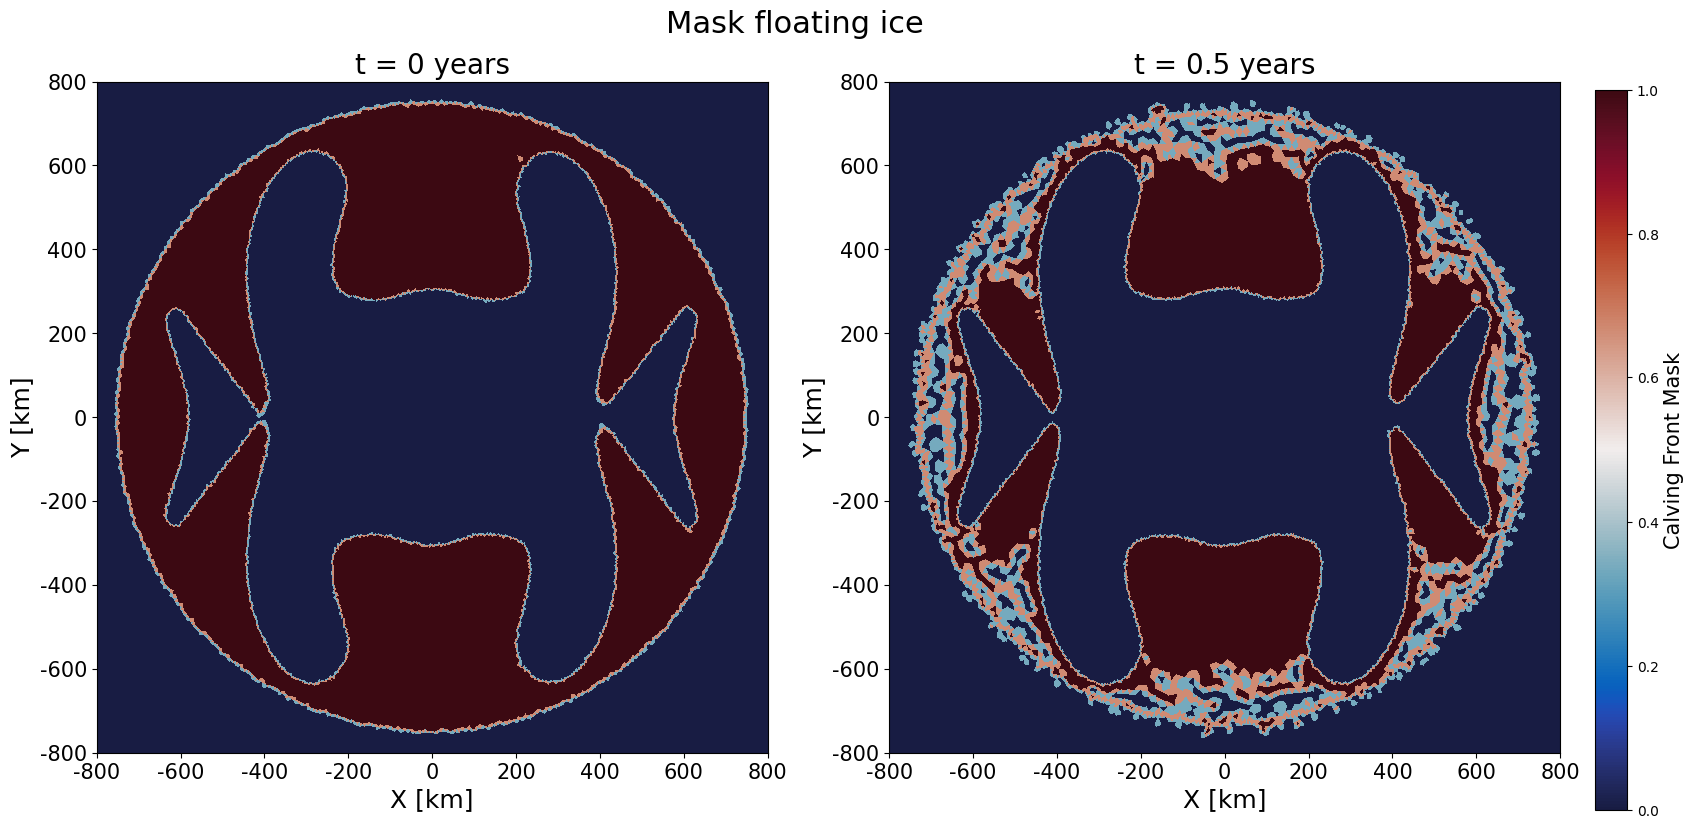

In [21]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang1t, mask_float1[0], cmap=cmo.balance)
ax[0].set_title('t = 0 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang2t, mask_float2[5], cmap=cmo.balance)
ax[1].set_title('t = 0.5 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Mask floating ice', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/3985331340.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


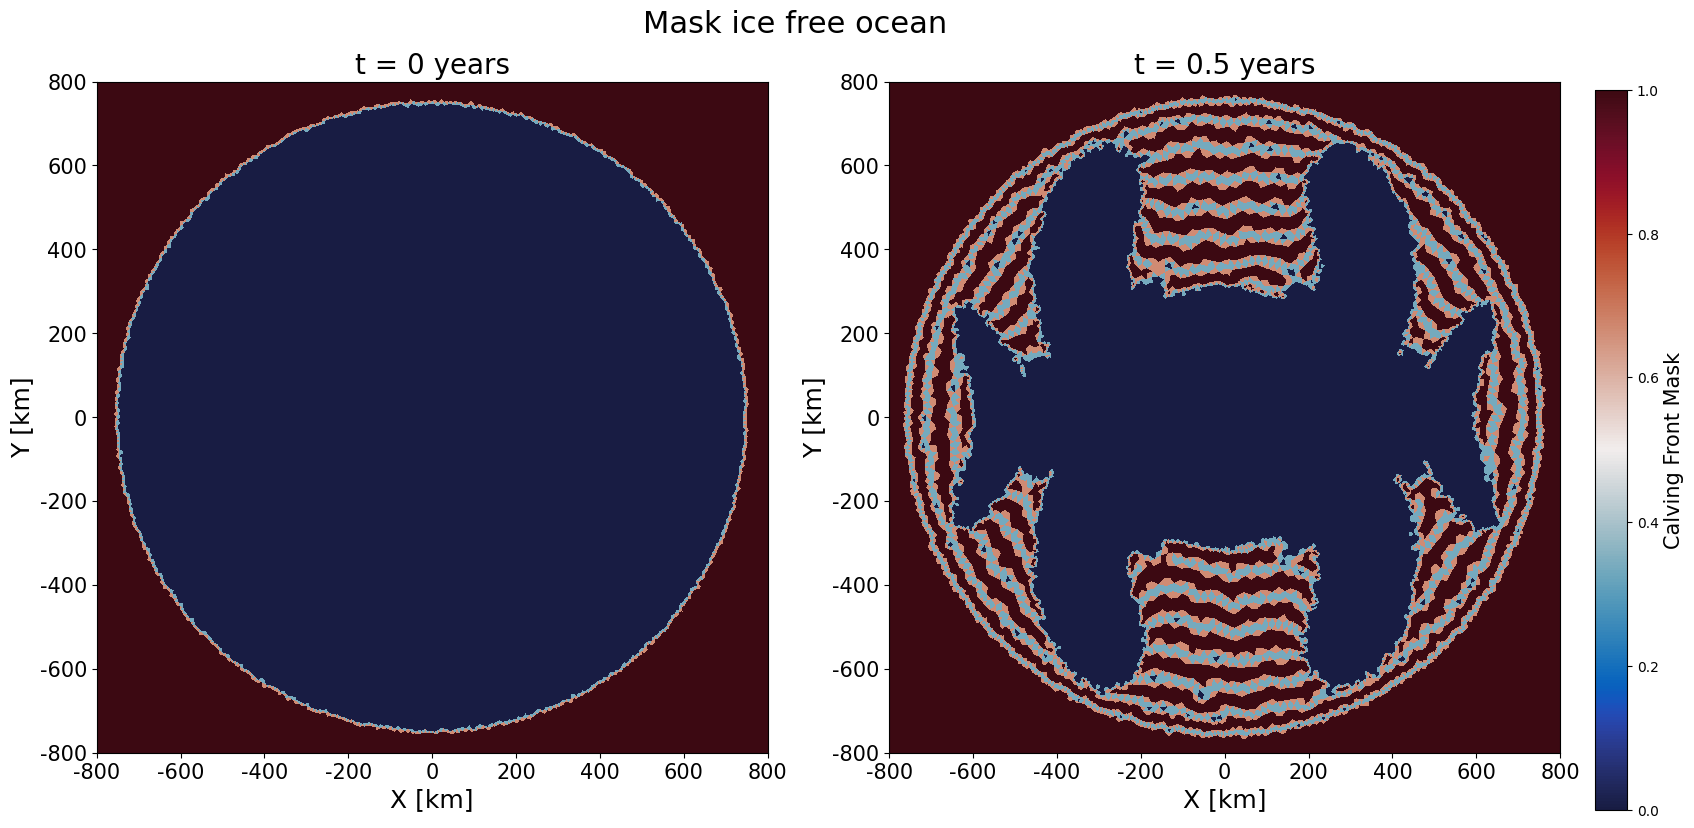

In [132]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang1t, mask_icefree1[0], cmap=cmo.balance)
ax[0].set_title('t = 0 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang2t, mask_icefree2[0], cmap=cmo.balance)
ax[1].set_title('t = 0.5 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Mask ice free ocean', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_34044/1050895069.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


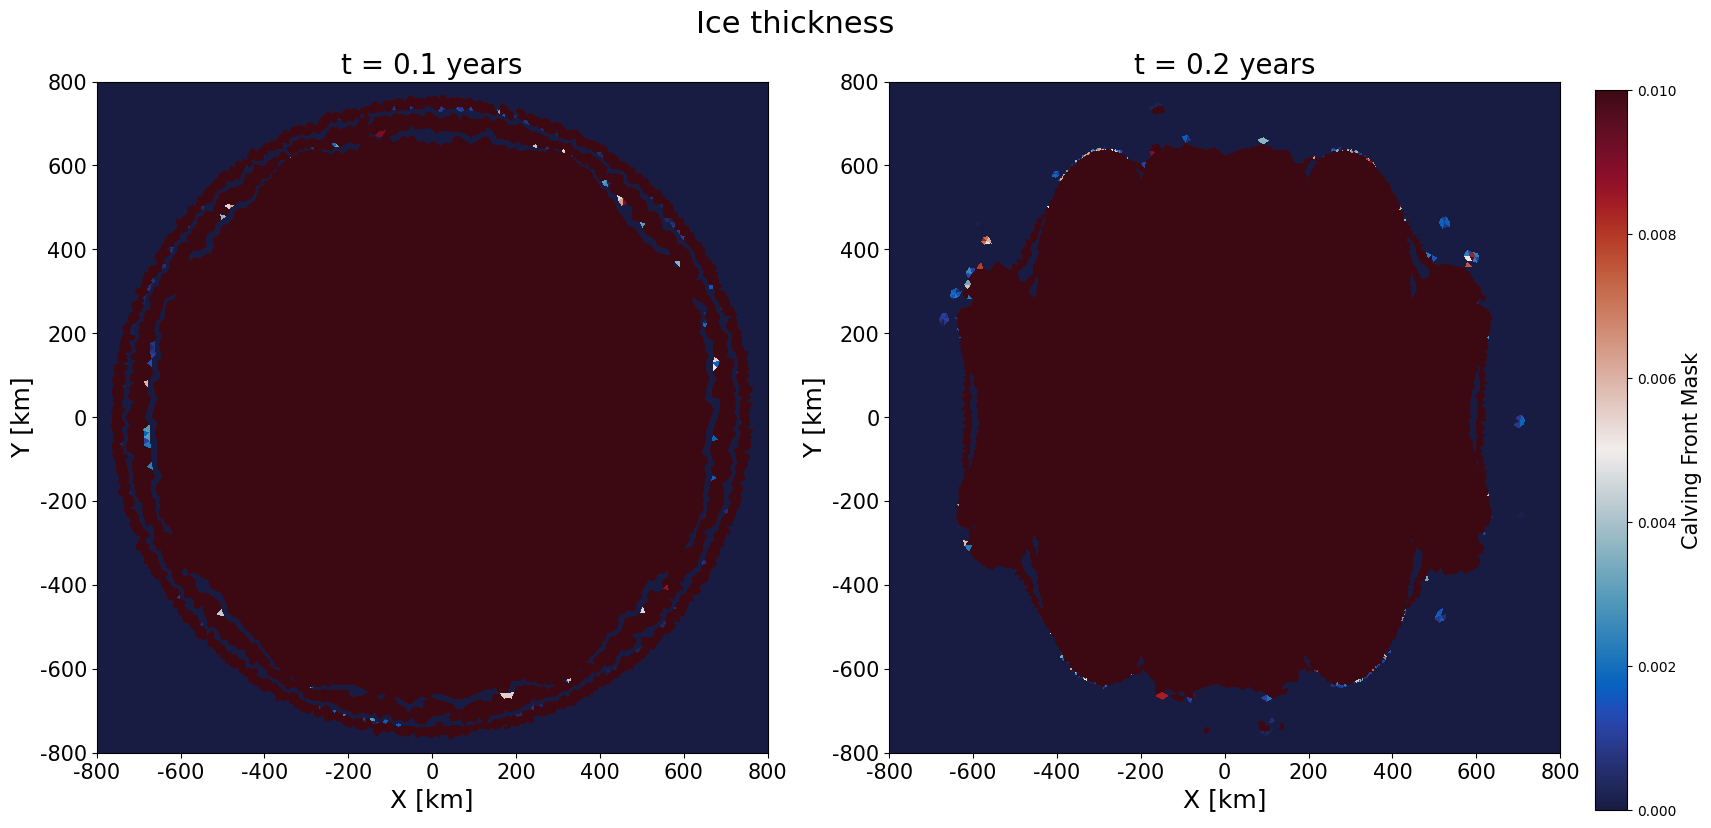

In [183]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang2t, Hi2t[0], cmap=cmo.balance, vmin = 0 , vmax = 0.01)
ax[0].set_title('t = 0.1 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang2t, Hi2t[1], cmap=cmo.balance, vmin = 0 , vmax = 0.01)
ax[1].set_title('t = 0.2 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Ice thickness', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/967331178.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


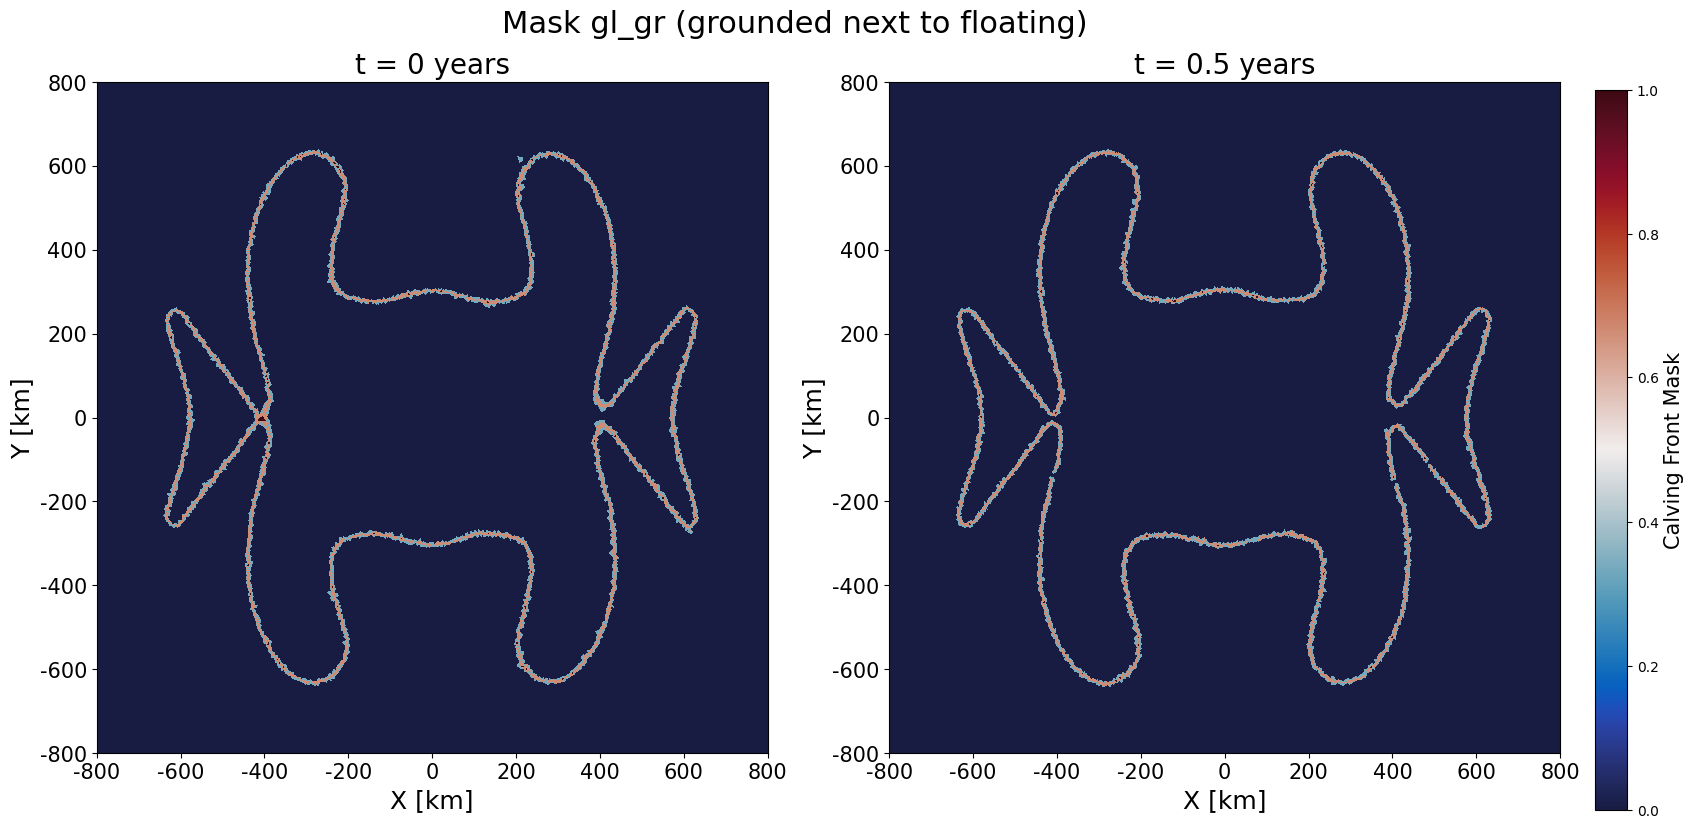

In [134]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang1t, mask_glgr1t[0], cmap=cmo.balance)
ax[0].set_title('t = 0 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang2t, mask_glgr2t[0], cmap=cmo.balance)
ax[1].set_title('t = 0.5 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Mask gl_gr (grounded next to floating)', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/2563565599.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


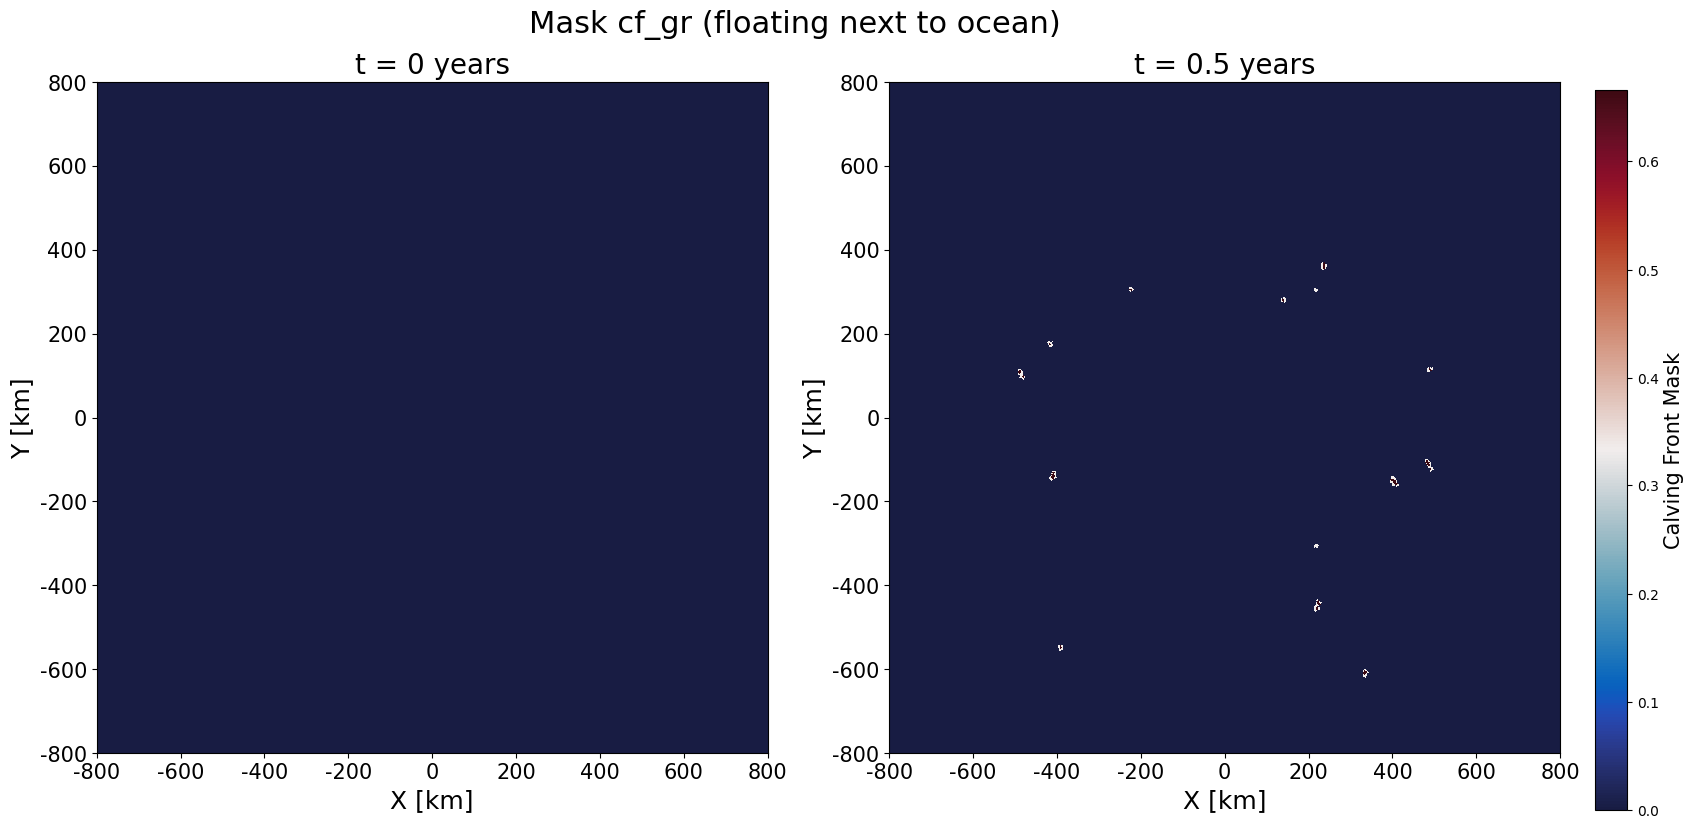

In [135]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang1t, mask_cfgr1[0], cmap=cmo.balance)
ax[0].set_title('t = 0 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang2t, mask_cfgr2[0], cmap=cmo.balance)
ax[1].set_title('t = 0.5 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Mask cf_gr (floating next to ocean)', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/3069049174.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


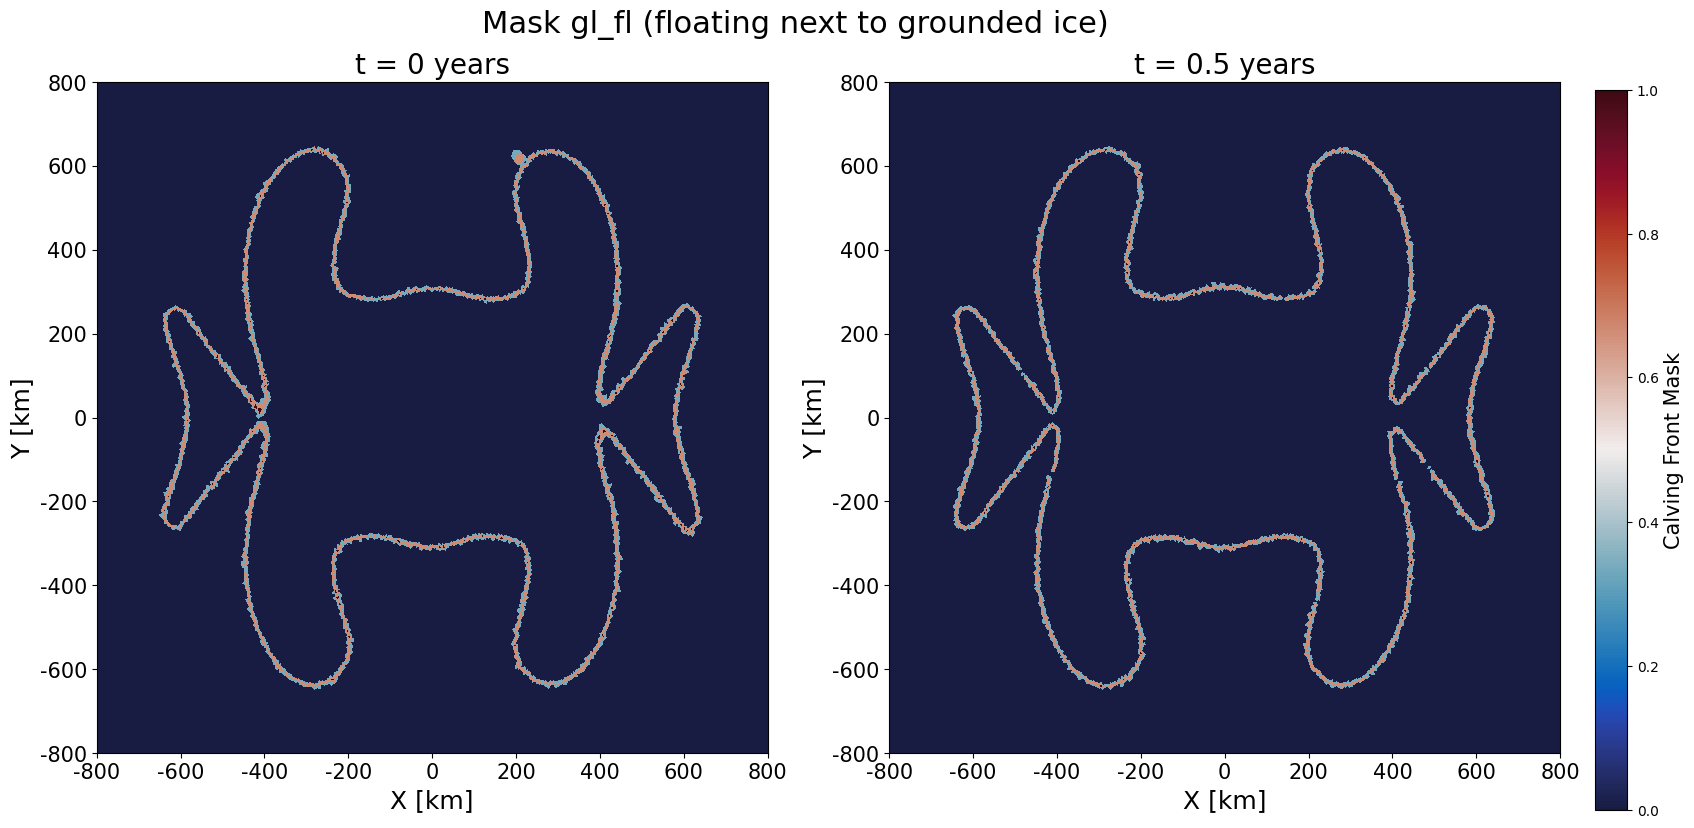

In [101]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

c0 = ax[0].tripcolor(triang1t, mask_glfl1[0], cmap=cmo.balance)
ax[0].set_title('t = 0 years', fontsize=tfs)

c1 = ax[1].tripcolor(triang2t, mask_glfl2[0], cmap=cmo.balance)
ax[1].set_title('t = 0.5 years', fontsize=tfs)

for i in range(2):
    ax[i].set_xlabel('X [km]', fontsize=afs)
    ax[i].set_ylabel('Y [km]', fontsize=afs)
    ax[i].set_xticks(np.arange(-n, n + 1, 200000))
    ax[i].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_yticks(np.arange(-n, n + 1, 200000))
    ax[i].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
    ax[i].set_xlim(-n, n)
    ax[i].set_ylim(-n, n)
    ax[i].set_aspect('equal')

# Single colorbar for both plots
plt.suptitle('Mask gl_fl (floating next to grounded ice)', fontsize=tfs+2, y=1.0)
cbar_ax = fig.add_axes([1, 0.0, 0.02, 0.9])  # [left, bottom, width, height]
cbar = fig.colorbar(c1, cax=cbar_ax)
cbar.set_label("Calving Front Mask", fontsize=ctfs)
plt.tight_layout()
plt.show()

# Results

## Ice thickness and elevation YEAR 0

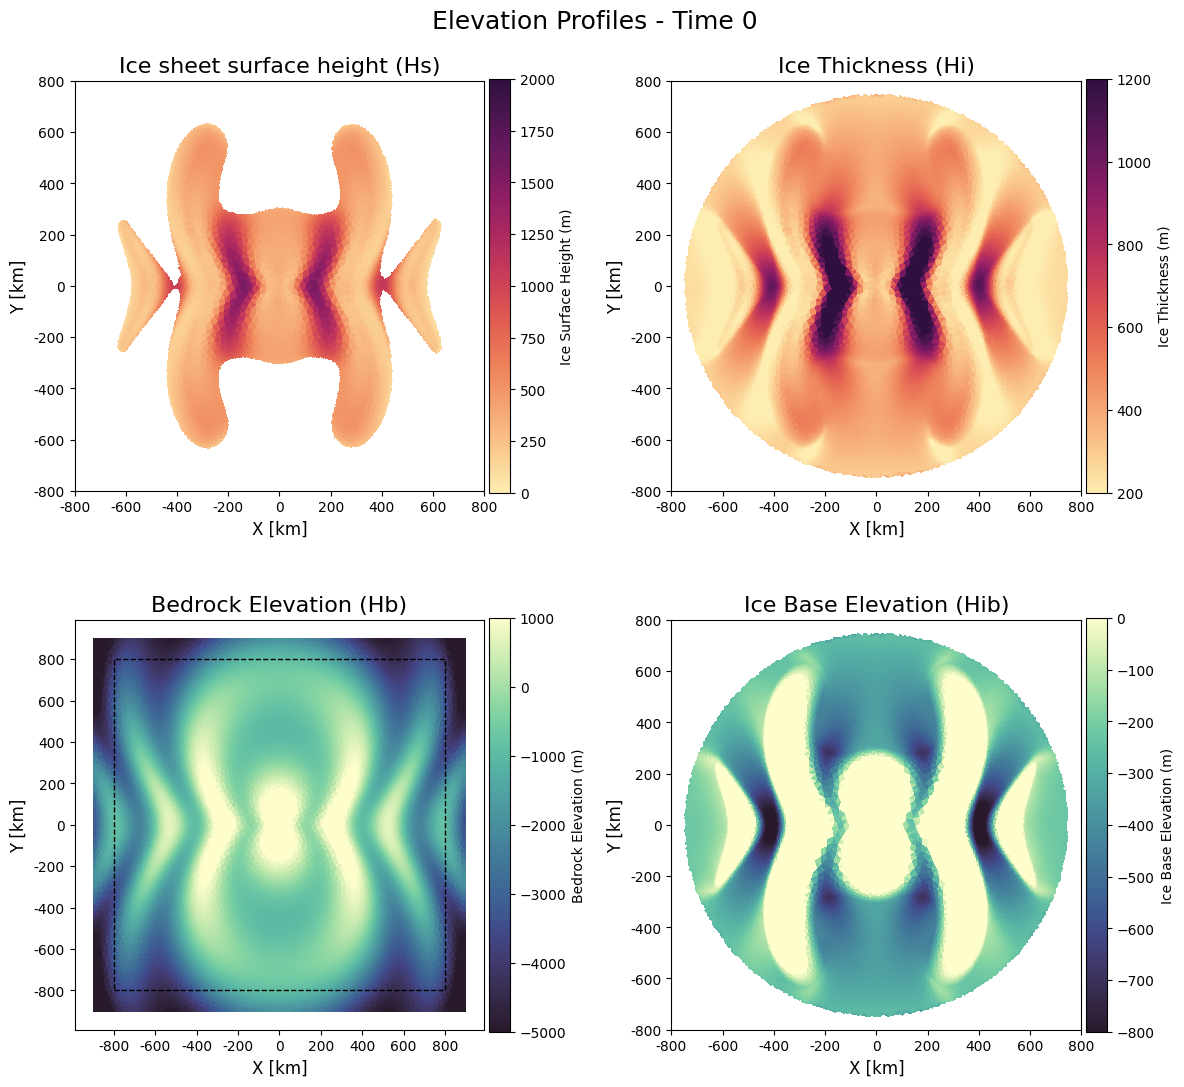

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(f'Elevation Profiles - Time {u}', fontsize=18, x=0.5, y=0.92)


c0 = ax[0, 0].tripcolor(triang1, Hs1[0].where(mask_gr1[0]), cmap=cmo.matter, vmin = 0 , vmax = 2000)
fig.colorbar(c0, ax=ax[0, 0], label="Ice Surface Height (m)", **colorbar_kwargs)
ax[0, 0].set_title('Ice sheet surface height (Hs)', fontsize=14)
#cont0 = ax[0, 0].tricontour(triang, Hs_l[u], levels=[0, 500, 1000, 1500], colors='k', linewidths=1)
#ax[0, 0].clabel(cont0, inline=True, fontsize=8)
ax[0, 0].set_xlim(-n,n)
ax[0, 0].set_ylim(-n,n)


c1 = ax[0, 1].tripcolor(triang1, Hi1[0].where(mask_ocean1), cmap=cmo.matter, vmin = 200, vmax=1200)
fig.colorbar(c1, ax=ax[0, 1], label="Ice Thickness (m)", **colorbar_kwargs)
ax[0, 1].set_title('Ice Thickness (Hi)', fontsize=14)
#cont1 = ax[0, 1].tricontour(triang, Hi_l[u], levels=[0, 500, 1000, 1500], colors='k', linewidths=1)
#ax[0, 1].clabel(cont1, inline=True, fontsize=8)
ax[0, 1].set_xlim(-n,n)
ax[0, 1].set_ylim(-n,n)


c2 = ax[1, 0].tripcolor(triang1, Hb1[0], cmap=cmo.deep_r, vmin=-5000, vmax=1000)
fig.colorbar(c2, ax=ax[1, 0], label="Bedrock Elevation (m)", **colorbar_kwargs)
ax[1, 0].set_title('Bedrock Elevation (Hb)', fontsize=14)
#cont2 = ax[1, 0].tricontour(triang, Hb_l[u], levels=[-700, -500, -250, 0, 250], colors='k', linewidths=1)
#ax[1, 0].clabel(cont2, inline=True, fontsize=8)
box_x = [-800000, 800000, 800000, -800000, -800000]
box_y = [-800000, -800000, 800000, 800000, -800000]
ax[1, 0].plot(box_x, box_y, color='black', linestyle='--', linewidth=1)


c3 = ax[1, 1].tripcolor(triang1, Hib1[0].where(mask_ocean1), cmap=cmo.deep_r , vmin = -800, vmax=0)
fig.colorbar(c3, ax=ax[1, 1], label="Ice Base Elevation (m)", **colorbar_kwargs)
ax[1, 1].set_title('Ice Base Elevation (Hib)', fontsize=14)
#cont3 = ax[1, 1].tricontour(triang, Hs_l[u] - Hi_l[u], levels=[-600, -300, 0, 300], colors='k', linewidths=1)
#ax[1, 1].clabel(cont3, inline=True, fontsize=8)
ax[1, 1].set_xlim(-n,n)
ax[1, 1].set_ylim(-n,n)
 

for i in range(2):
    for j in range(2):
        ax[i, j].set_aspect('equal')
        ax[i, j].title.set_fontsize(16)
        ax[i, j].set_xlabel('X [km]', fontsize=12)
        ax[i, j].set_ylabel('Y [km]', fontsize=12)
        ax[i, j].set_xticks(np.arange(-n, n + 1, 200000))
        ax[i, j].set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
        ax[i, j].set_yticks(np.arange(-n, n + 1, 200000))
        ax[i, j].set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### COLD

In [7]:
# Define colormap and normalization
cmapHi = cmo.haline_r
#boundsHi = [300,400,500,600,700,800]
boundsHi = [0,325,375]
normHi = mpl.colors.BoundaryNorm(boundsHi, cmapHi.N, extend='max')

# Define colormap and normalization
cmapBMB = mpl.colormaps['spring']
#bounds = [-0.6, -0.4, -0.2, 0.0 ,0.2]  # Extended to include 0
boundsBMB = [-2, -1.5, -1, -0.5,0, 0.5] 
normBMB = mpl.colors.BoundaryNorm(boundsBMB, cmapBMB.N, extend='max')



/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/3959064840.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


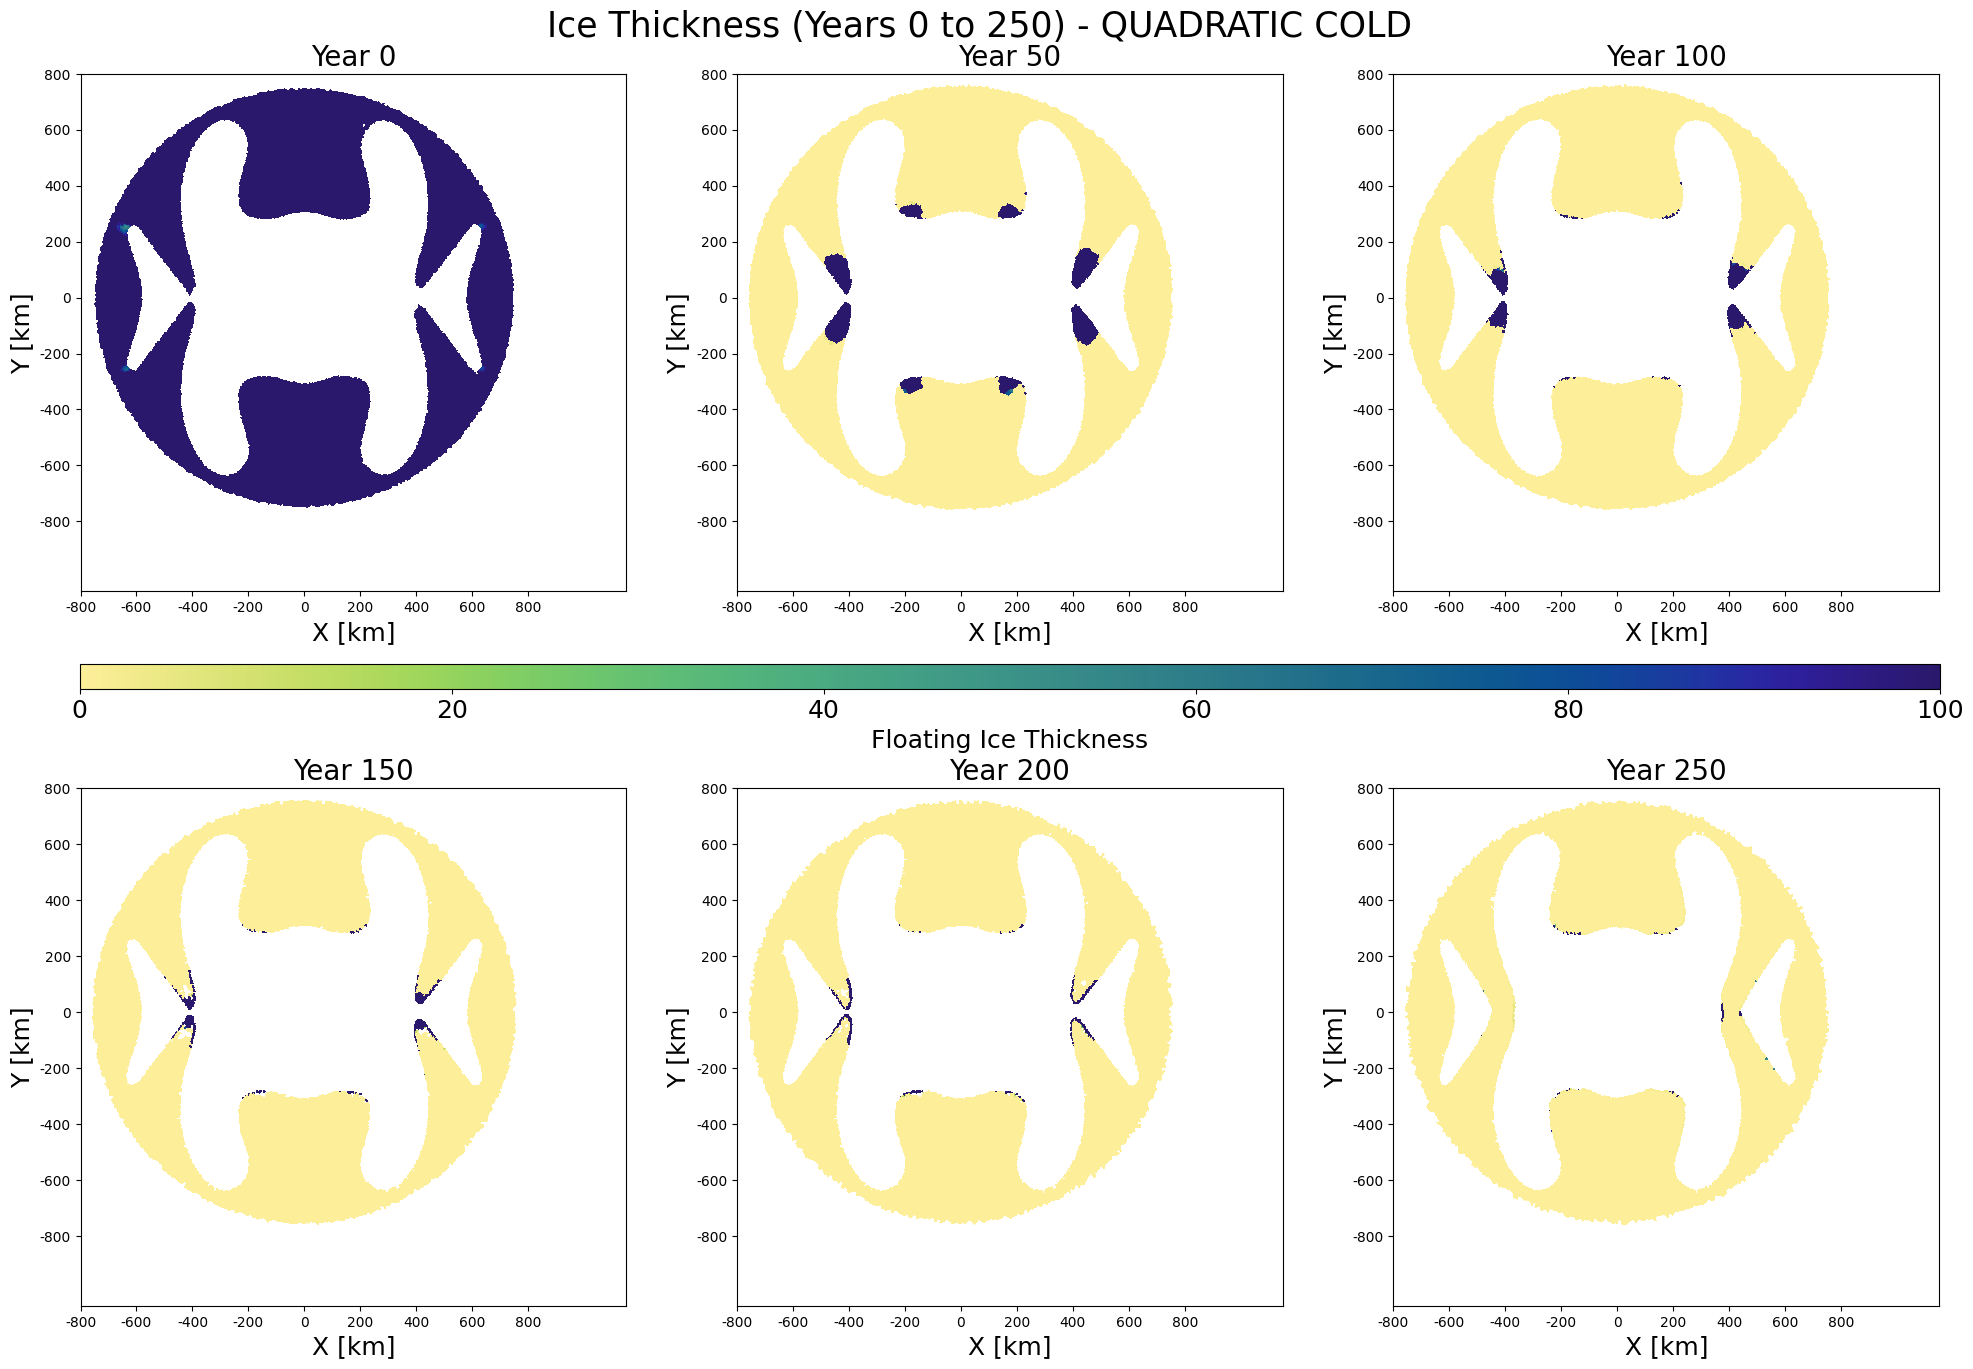

In [10]:
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row


c0 = axes[0].tripcolor(triang1, Hi1[0].where(~mask_gr1[0].astype(bool)).where(Hi1[0]!=0), cmap=cmo.haline_r, vmin = 0, vmax = 100)
c50 = axes[1].tripcolor(triang2, Hi2[0].where(~mask_gr2[0].astype(bool)).where(Hi2[0]!=0), cmap=cmo.haline_r, vmin = 0, vmax = 100)
c100= axes[2].tripcolor(triang2, Hi2[1].where(~mask_gr2[1].astype(bool)).where(Hi2[1]!=0),cmap=cmo.haline_r, vmin = 0, vmax = 100)
c150 = axes[3].tripcolor(triang2, Hi2[2].where(~mask_gr2[2].astype(bool)).where(Hi2[2]!=0),cmap=cmo.haline_r, vmin = 0, vmax = 100)
c200 = axes[4].tripcolor(triang2, Hi2[3].where(~mask_gr2[3].astype(bool)).where(Hi2[3]!=0),cmap=cmo.haline_r, vmin = 0, vmax = 100)
c250 = axes[5].tripcolor(triang3, Hi3[-1].where(~mask_gr3[-1].astype(bool)).where(Hi3[-1]!=0),cmap=cmo.haline_r, vmin = 0, vmax = 100)



for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

# Create nested gridspec for the middle row to accommodate two colorbars
middle_row_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1, :], height_ratios=[1, 1], hspace=0.05)

# Add colorbars - one on top of the other
cbar_ax1 = plt.subplot(middle_row_gs[0])  # Top colorbar
cbar1 = fig.colorbar(c0, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Floating Ice Thickness', fontsize=afs)
cbar1.ax.tick_params(labelsize=afs)


plt.suptitle('Ice Thickness (Years 0 to 250) - QUADRATIC COLD', fontsize=tfs+5, y=0.92)  
plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/1387979207.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


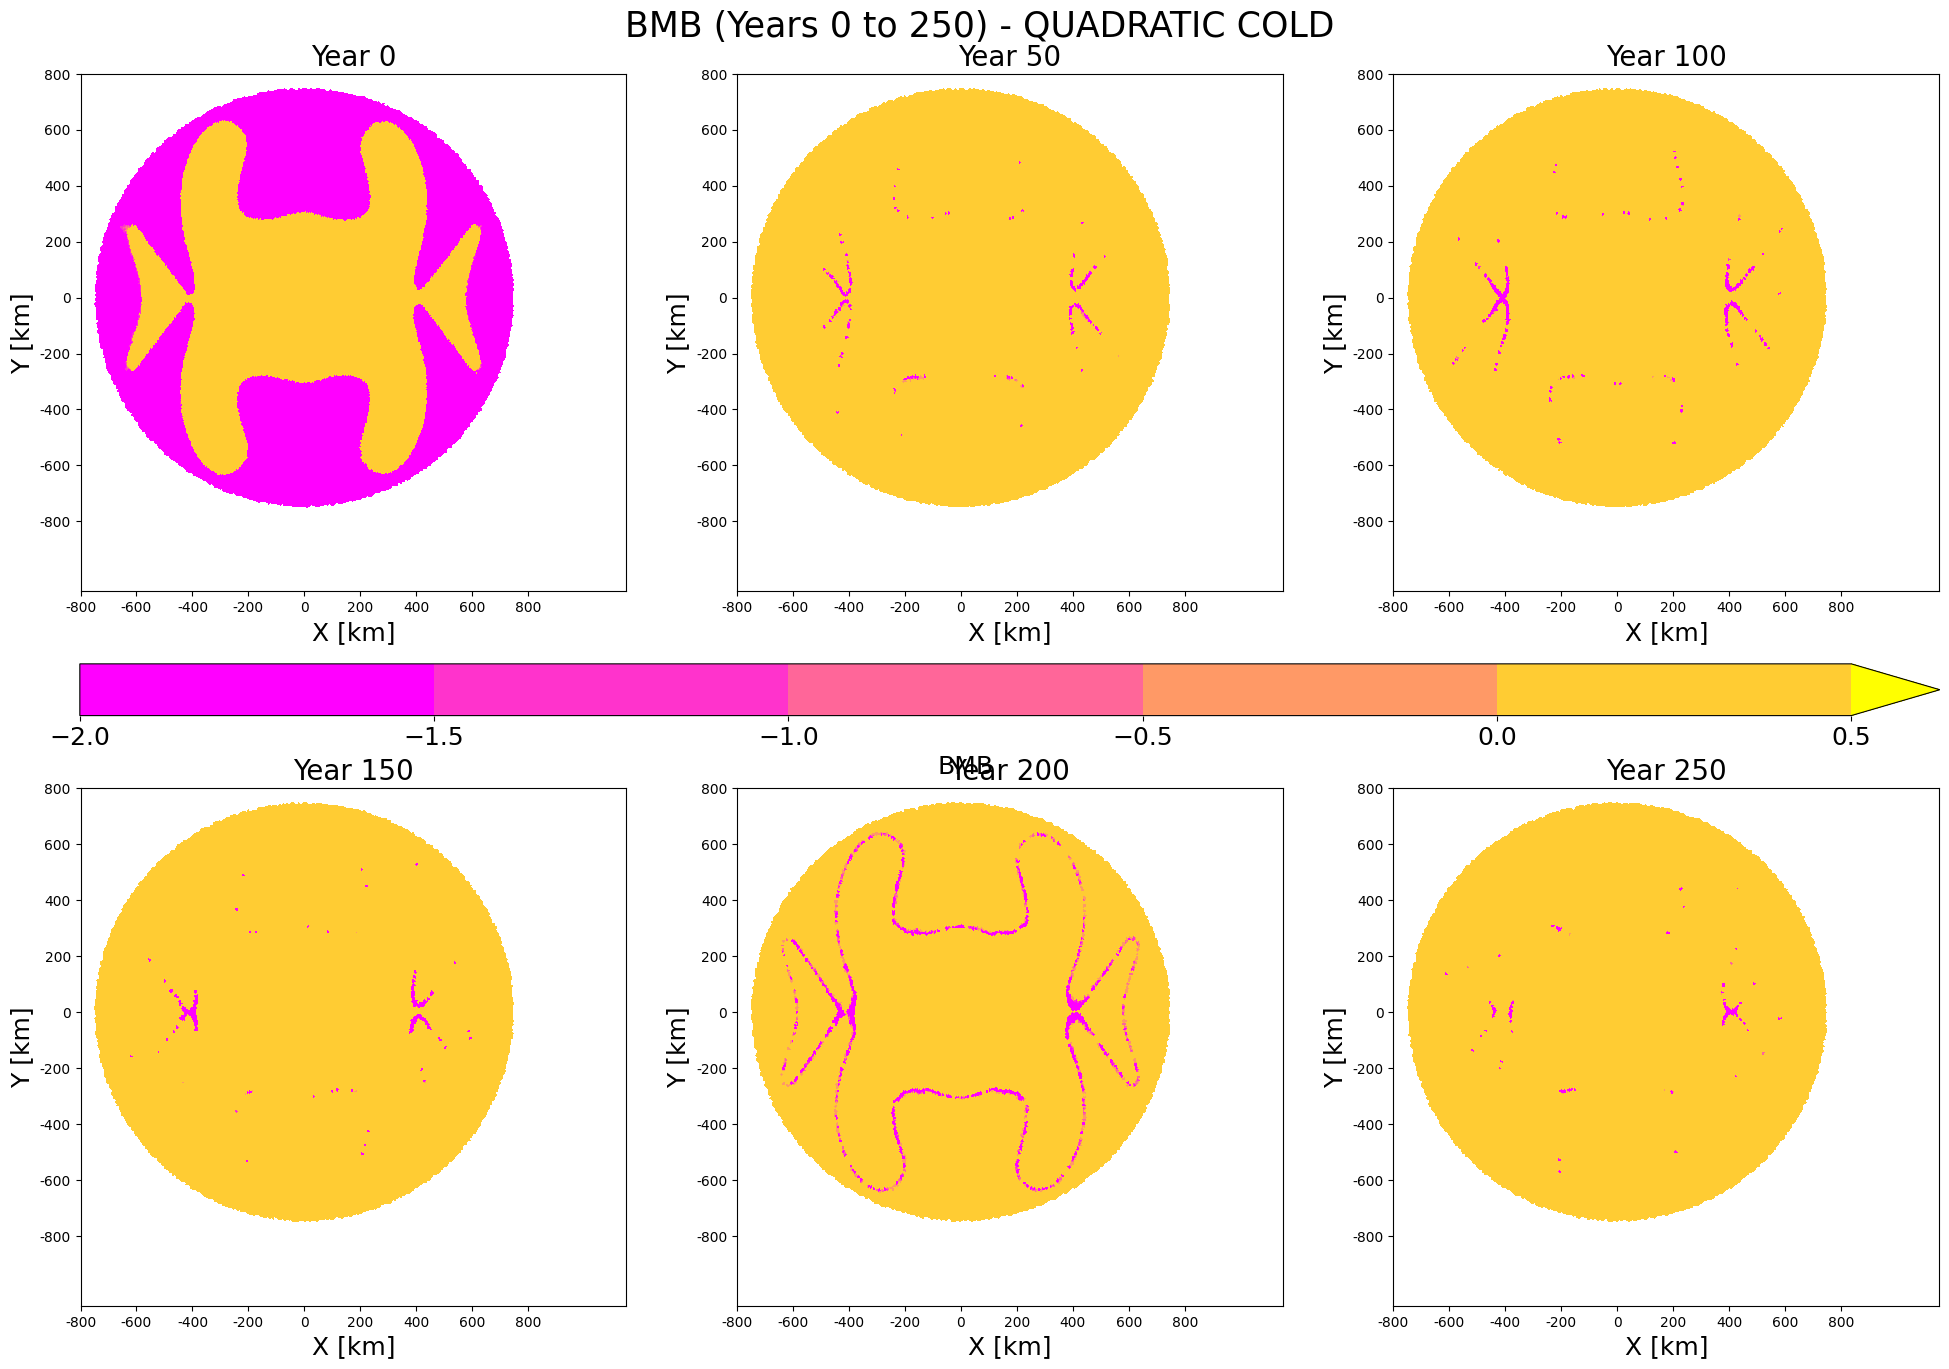

In [11]:
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

# Plot ice thickness
c0 = axes[0].tripcolor(triang1, BMB1[0].where(mask_ocean1),norm = normBMB, cmap=cmapBMB)
c50 = axes[1].tripcolor(triang2, BMB2[4].where(mask_ocean2),norm = normBMB, cmap=cmapBMB)
c100= axes[2].tripcolor(triang2, BMB2[9].where(mask_ocean2),norm = normBMB, cmap=cmapBMB)
c150 = axes[3].tripcolor(triang2, BMB2[14].where(mask_ocean2),norm = normBMB, cmap=cmapBMB)
c200 = axes[4].tripcolor(triang3, BMB3[1].where(mask_ocean3),norm = normBMB, cmap=cmapBMB)
c250 = axes[5].tripcolor(triang3, BMB3[6].where(mask_ocean3),norm = normBMB, cmap=cmapBMB)


for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

# Add colorbar using the middle row of the gridspec
cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('BMB', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)


plt.suptitle('BMB (Years 0 to 250) - QUADRATIC COLD', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

### WARM

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/397719579.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


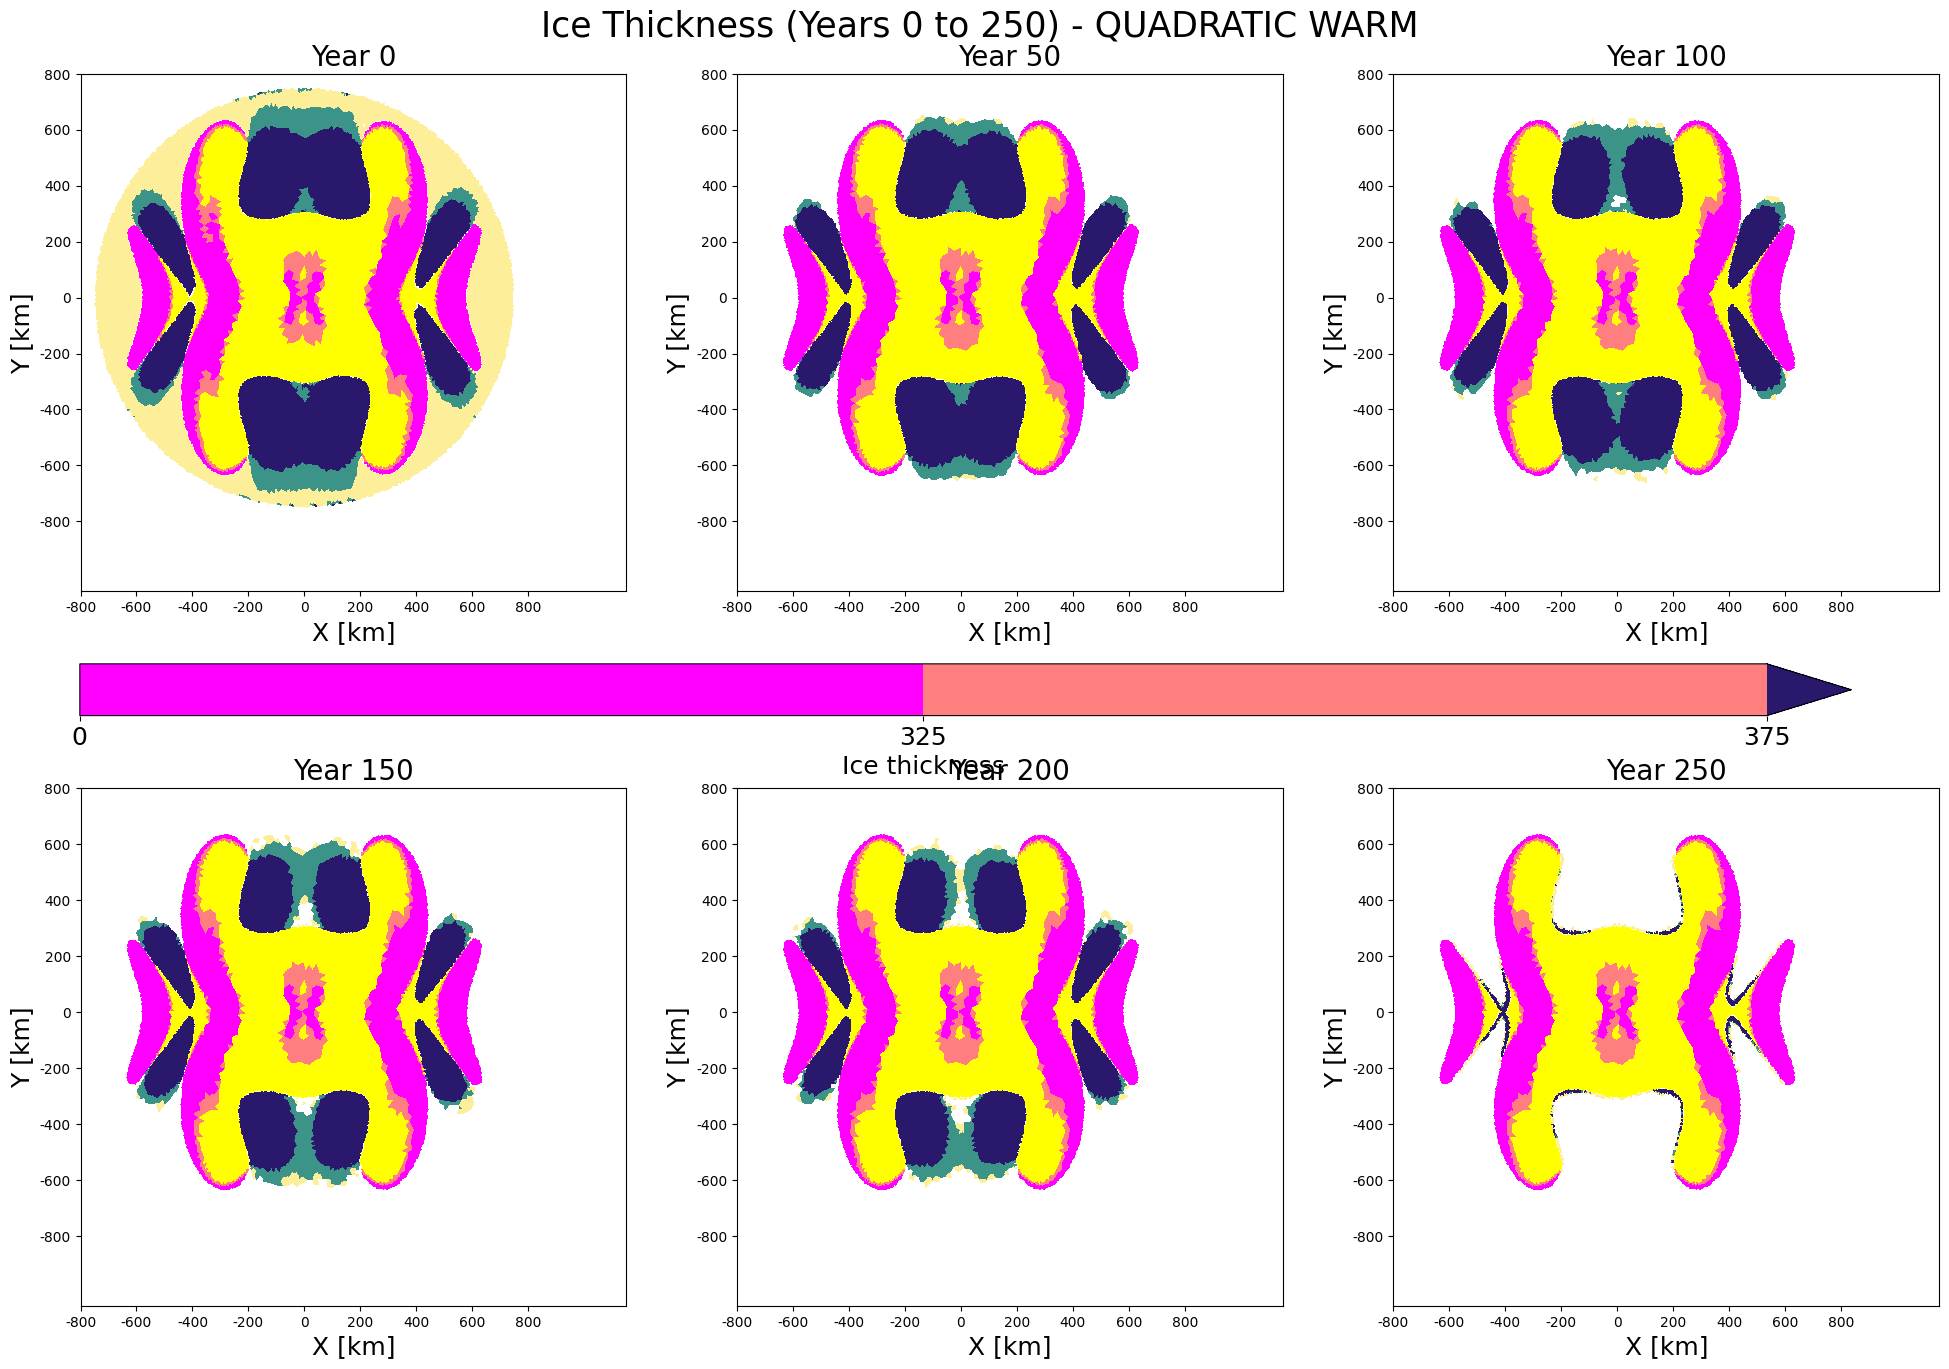

In [12]:
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

# Plot ice thickness
c0 = axes[0].tripcolor(triang1w, Hi1w[0].where(~mask_gr1w[0].astype(bool)).where(Hi1w[0]!=0), norm=normHi, cmap=cmapHi)
c50 = axes[1].tripcolor(triang2w, Hi2w[0].where(~mask_gr2w[0].astype(bool)).where(Hi2w[0]!=0),  norm = normHi, cmap=cmapHi)
c100= axes[2].tripcolor(triang2w, Hi2w[1].where(~mask_gr2w[1].astype(bool)).where(Hi2w[1]!=0),  norm = normHi,cmap=cmapHi)
c150 = axes[3].tripcolor(triang2w, Hi2w[2].where(~mask_gr2w[2].astype(bool)).where(Hi2w[2]!=0),  norm = normHi,cmap=cmapHi)
c200 = axes[4].tripcolor(triang2w, Hi2w[3].where(~mask_gr2w[3].astype(bool)).where(Hi2w[3]!=0), norm = normHi,cmap=cmapHi)
c250 = axes[5].tripcolor(triang2w, Hi2w[-1].where(~mask_gr2w[-1].astype(bool)).where(Hi2w[-1]!=0),  norm = normHi,cmap=cmapHi)


c01 = axes[0].tripcolor(triang1w, Hi1w[0].where(mask_gr1w[0].astype(bool)).where(Hi1w[0]!=0), norm=normHi, cmap=cmapBMB)
c501 = axes[1].tripcolor(triang2w, Hi2w[0].where(mask_gr2w[0].astype(bool)).where(Hi2w[0]!=0),  norm = normHi, cmap=cmapBMB)
c1001= axes[2].tripcolor(triang2w, Hi2w[1].where(mask_gr2w[1].astype(bool)).where(Hi2w[1]!=0),  norm = normHi,cmap=cmapBMB)
c1501 = axes[3].tripcolor(triang2w, Hi2w[2].where(mask_gr2w[2].astype(bool)).where(Hi2w[2]!=0),  norm = normHi,cmap=cmapBMB)
c2001 = axes[4].tripcolor(triang2w, Hi2w[3].where(mask_gr2w[3].astype(bool)).where(Hi2w[3]!=0), norm = normHi,cmap=cmapBMB)
c2501 = axes[5].tripcolor(triang2w, Hi2w[-1].where(mask_gr2w[-1].astype(bool)).where(Hi2w[-1]!=0),  norm = normHi,cmap=cmapBMB)

#axes[0].plot(GL1[:, 0], GL1[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[1].plot(GL2[:, 0], GL2[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[2].plot(GL2[:, 0], GL2[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[3].plot(GL2[:, 0], GL2[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[4].plot(GL3[:, 0], GL3[:, 1], 'k--', linewidth=2, label='Grounding Line')
#axes[5].plot(GL3[:, 0], GL3[:, 1], 'k--', linewidth=2, label='Grounding Line')

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')


# Add colorbar using the middle row of the gridspec
cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Ice thickness', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)

cbar_ax1 = plt.subplot(gs[1, :])  # Middle row, all columnsx
cbar1 = fig.colorbar(c01, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Ice thickness', fontsize=afs)
cbar1.ax.tick_params(labelsize=afs)


plt.suptitle('Ice Thickness (Years 0 to 250) - QUADRATIC WARM', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

/var/folders/qd/ggy847q57w1d6rr22f838tvm0000gn/T/ipykernel_7035/944731879.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


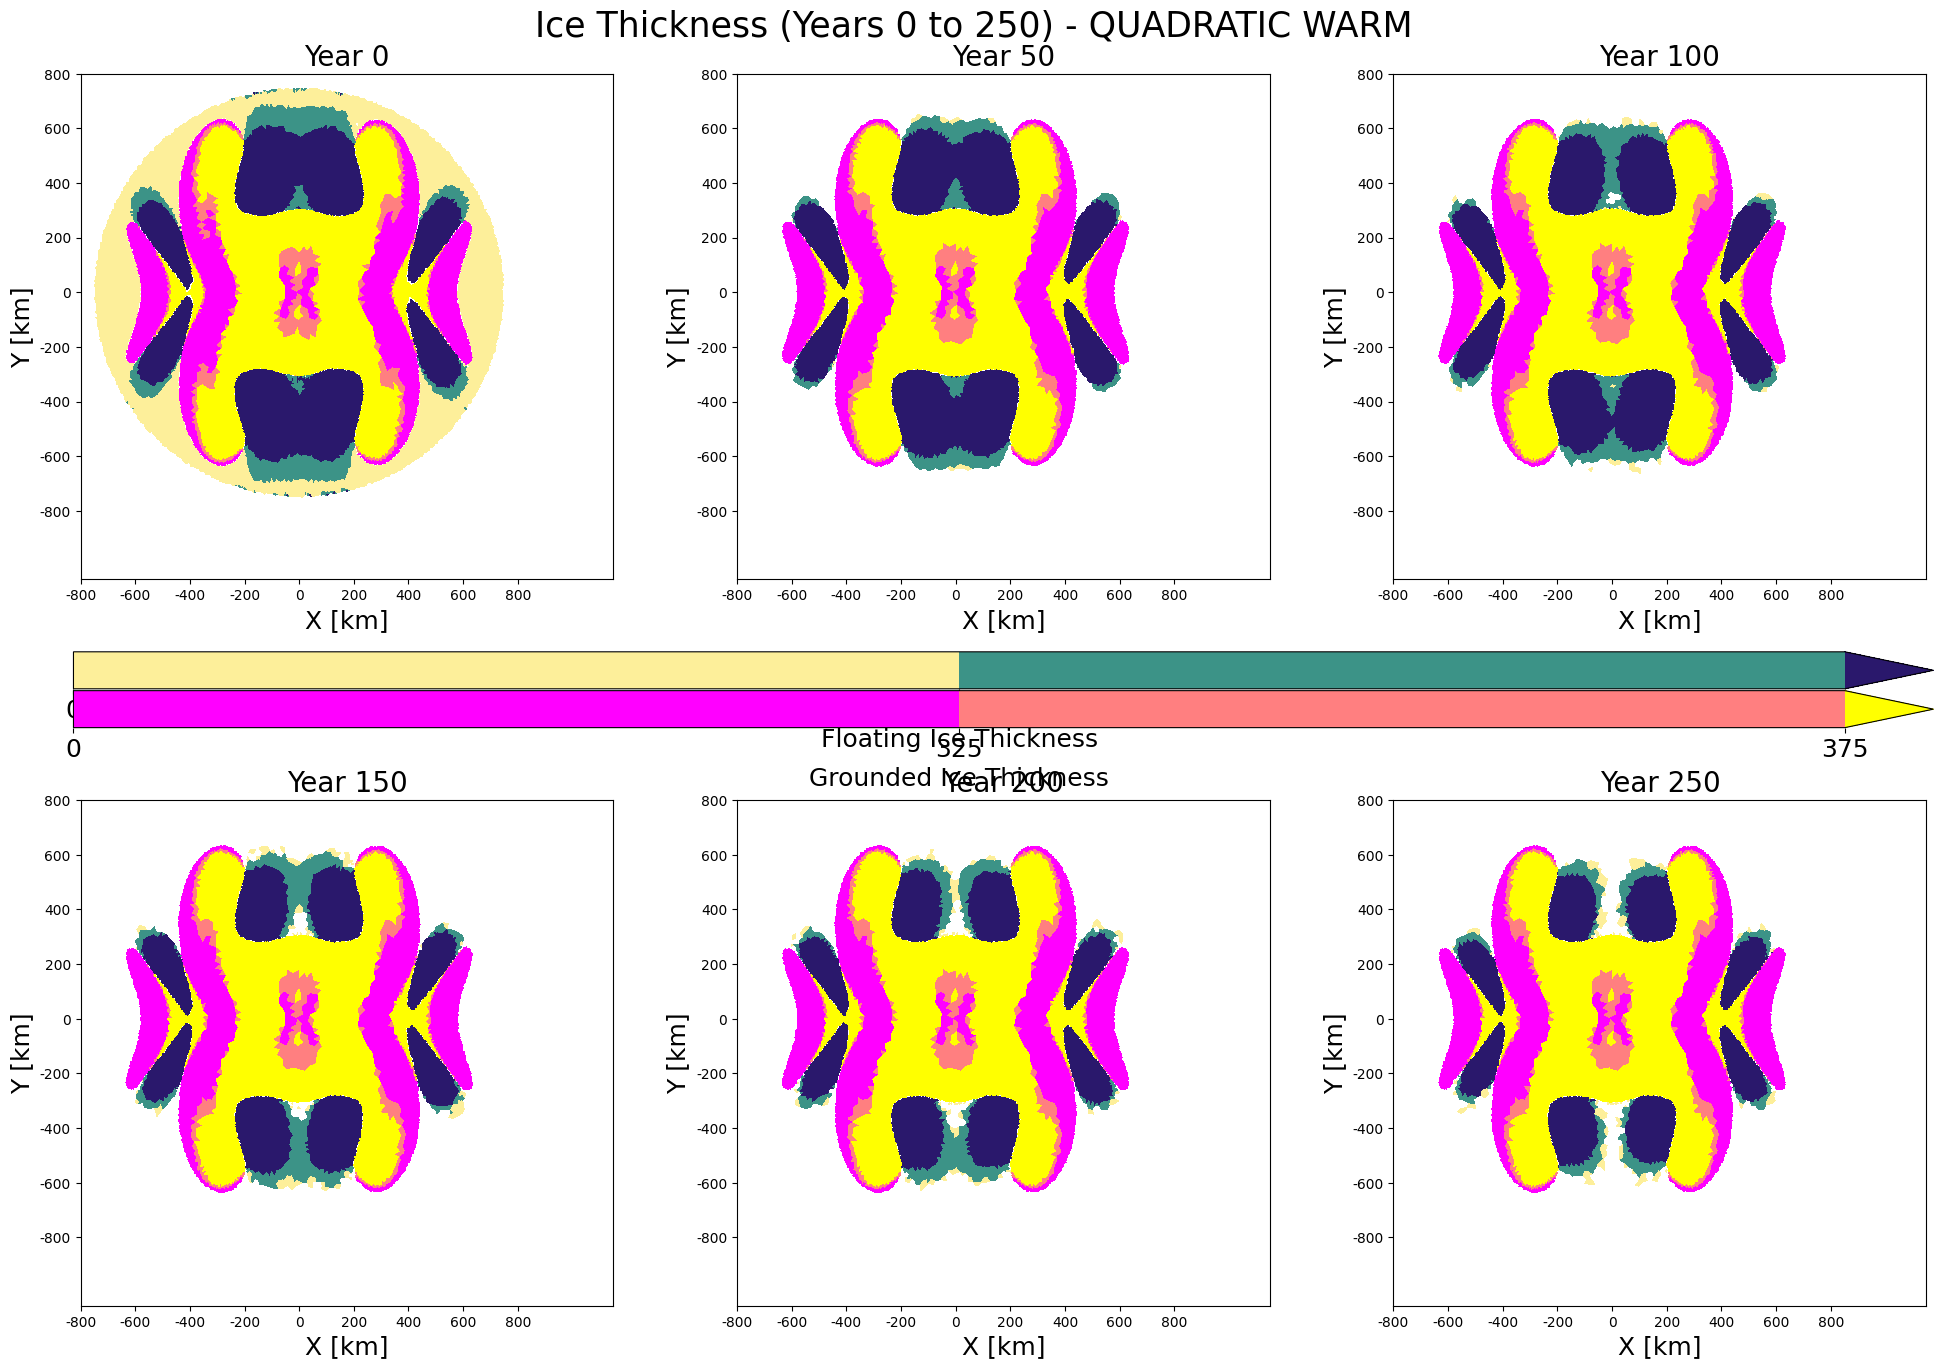

In [13]:
fig = plt.figure(figsize=(24, 16))
# Adjust height ratios to accommodate two colorbars
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.15, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

# Plot ice thickness
c0 = axes[0].tripcolor(triang1w, Hi1w[0].where(~mask_gr1w[0].astype(bool)).where(Hi1w[0]!=0), norm=normHi, cmap=cmapHi)
c50 = axes[1].tripcolor(triang2w, Hi2w[0].where(~mask_gr2w[0].astype(bool)).where(Hi2w[0]!=0),  norm = normHi, cmap=cmapHi)
c100= axes[2].tripcolor(triang2w, Hi2w[1].where(~mask_gr2w[1].astype(bool)).where(Hi2w[1]!=0),  norm = normHi,cmap=cmapHi)
c150 = axes[3].tripcolor(triang2w, Hi2w[2].where(~mask_gr2w[2].astype(bool)).where(Hi2w[2]!=0),  norm = normHi,cmap=cmapHi)
c200 = axes[4].tripcolor(triang2w, Hi2w[3].where(~mask_gr2w[3].astype(bool)).where(Hi2w[3]!=0), norm = normHi,cmap=cmapHi)
c250 = axes[5].tripcolor(triang2w, Hi2w[4].where(~mask_gr2w[4].astype(bool)).where(Hi2w[4]!=0),  norm = normHi,cmap=cmapHi)


c01 = axes[0].tripcolor(triang1w, Hi1w[0].where(mask_gr1w[0].astype(bool)).where(Hi1w[0]!=0), norm=normHi, cmap=cmapBMB)
c501 = axes[1].tripcolor(triang2w, Hi2w[0].where(mask_gr2w[0].astype(bool)).where(Hi2w[0]!=0),  norm = normHi, cmap=cmapBMB)
c1001= axes[2].tripcolor(triang2w, Hi2w[1].where(mask_gr2w[1].astype(bool)).where(Hi2w[1]!=0),  norm = normHi,cmap=cmapBMB)
c1501 = axes[3].tripcolor(triang2w, Hi2w[2].where(mask_gr2w[2].astype(bool)).where(Hi2w[2]!=0),  norm = normHi,cmap=cmapBMB)
c2001 = axes[4].tripcolor(triang2w, Hi2w[3].where(mask_gr2w[3].astype(bool)).where(Hi2w[3]!=0), norm = normHi,cmap=cmapBMB)
c2501 = axes[5].tripcolor(triang2w, Hi2w[4].where(mask_gr2w[4].astype(bool)).where(Hi2w[4]!=0),  norm = normHi,cmap=cmapBMB)

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

# Create nested gridspec for the middle row to accommodate two colorbars
middle_row_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1, :], height_ratios=[1, 1], hspace=0.05)

# Add colorbars - one on top of the other
cbar_ax1 = plt.subplot(middle_row_gs[0])  # Top colorbar
cbar1 = fig.colorbar(c0, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Floating Ice Thickness', fontsize=afs)
cbar1.ax.tick_params(labelsize=afs)

cbar_ax2 = plt.subplot(middle_row_gs[1])  # Bottom colorbar
cbar2 = fig.colorbar(c01, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Grounded Ice Thickness', fontsize=afs)
cbar2.ax.tick_params(labelsize=afs)

plt.suptitle('Ice Thickness (Years 0 to 250) - QUADRATIC WARM', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

NameError: name 'triang4w' is not defined

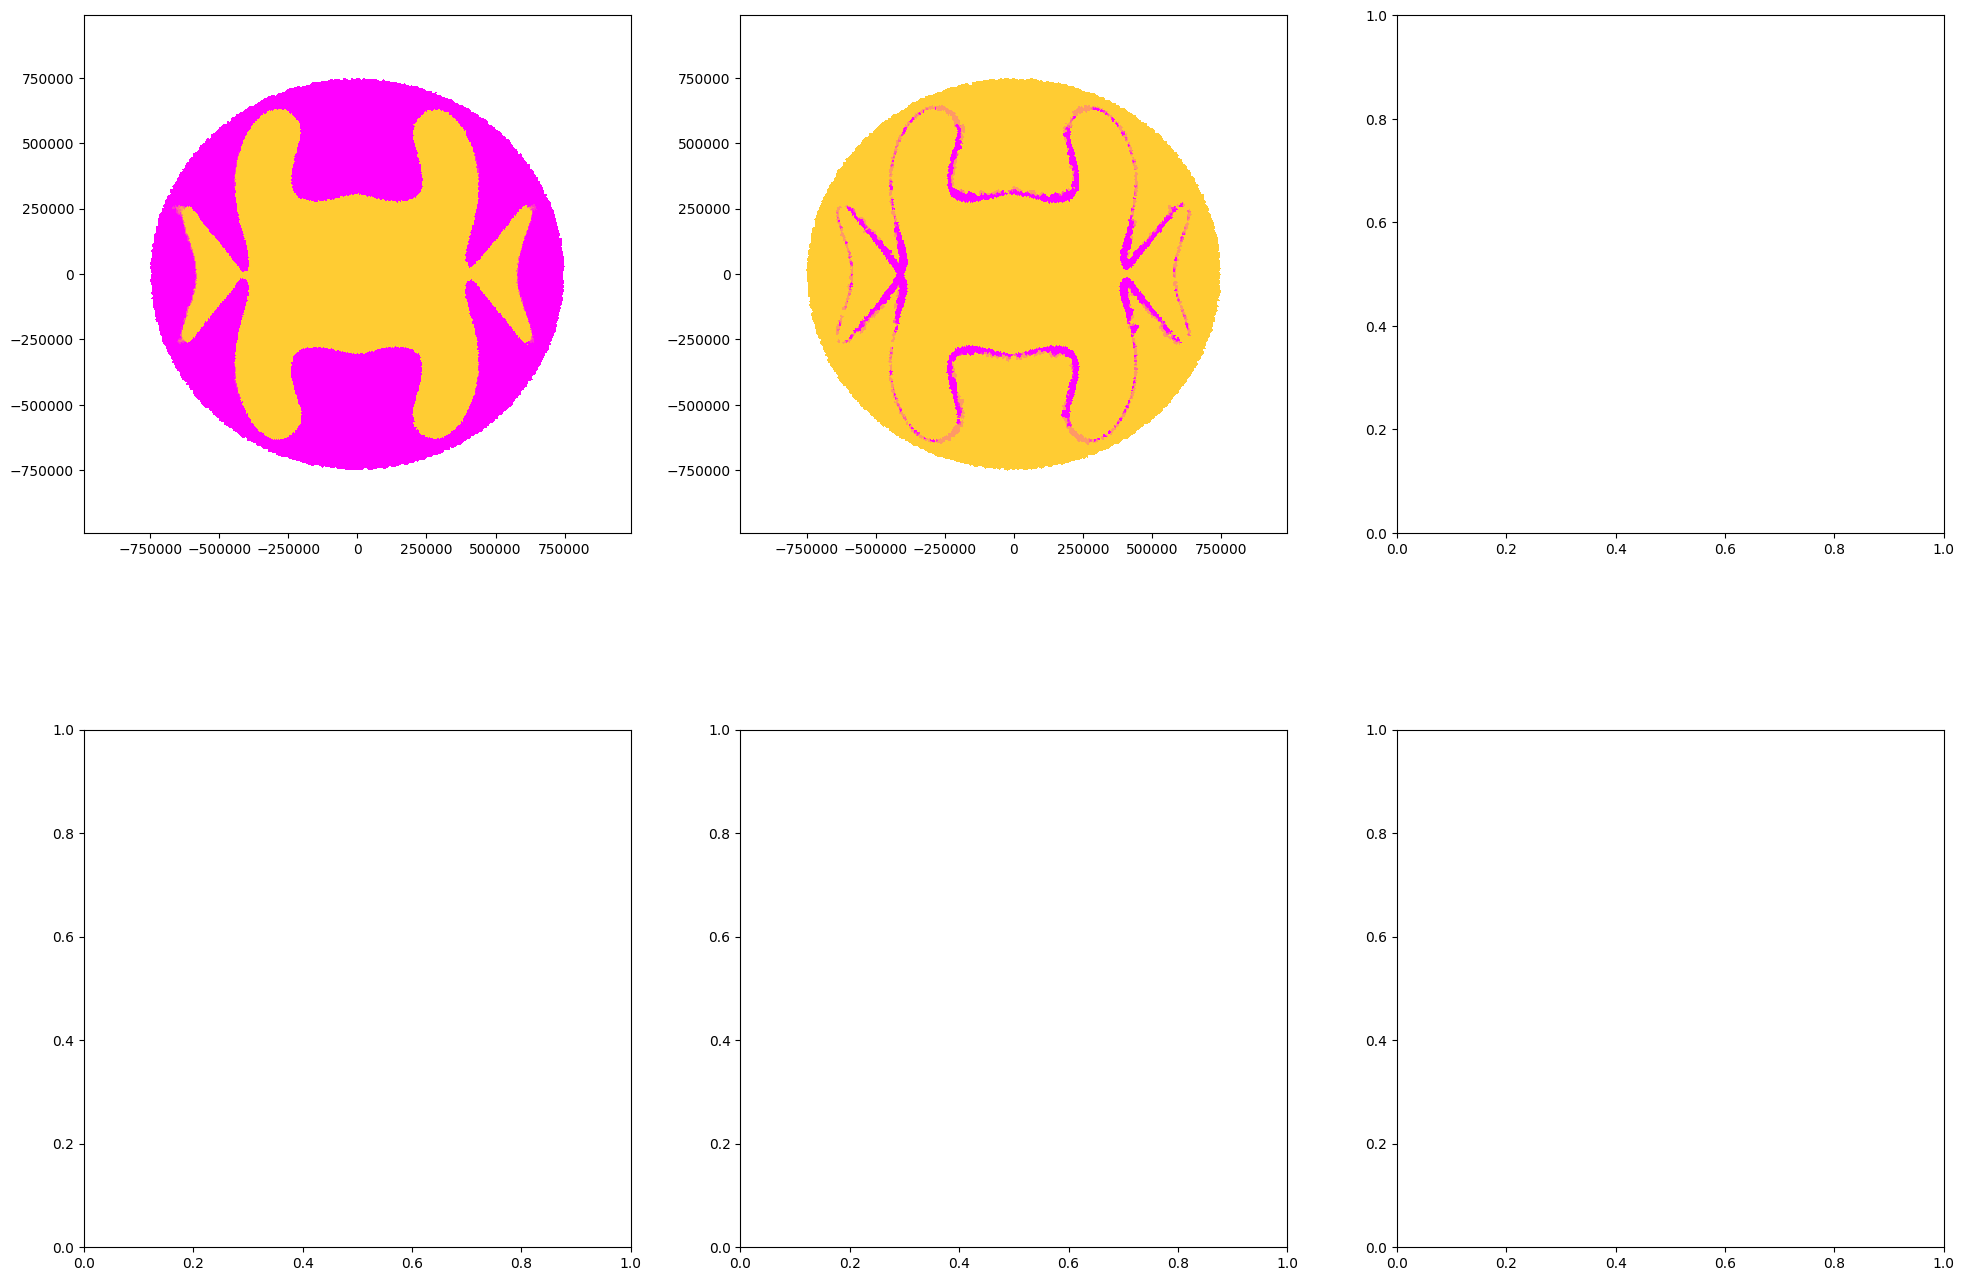

In [14]:
# Define colormap and normalization
cmap = mpl.colormaps['afmhot']
#bounds = [-6, -4, -2, 0] 
bounds = [-2, -1.5, -1, -0.5,0, 0.5] 
   # -20, -18, -16, -14, 12, -10 , -8, 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Create figure
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

# Plot ice thickness
c0 = axes[0].tripcolor(triang1w, BMB1w[0].where(mask_ocean1w),norm=normBMB, cmap=cmapBMB)
c50 = axes[1].tripcolor(triang3w, BMB3w[1].where(mask_ocean3w),norm=normBMB, cmap=cmapBMB)
c100 = axes[2].tripcolor(triang4w, BMB4w[3].where(mask_ocean4w),norm=normBMB, cmap=cmapBMB)
c150 = axes[3].tripcolor(triang5w, BMB5w[3].where(mask_ocean5w),norm=normBMB, cmap=cmapBMB)
c200 = axes[4].tripcolor(triang6w, BMB6w[1].where(mask_ocean6w),norm=normBMB, cmap=cmapBMB)
c250 = axes[5].tripcolor(triang6w, BMB6w[6].where(mask_ocean6w),norm=normBMB, cmap=cmapBMB)

for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year[i]}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')

plt.suptitle('BMB (Years 0 to 250) - QUADRATIC WARM', fontsize=tfs+5, y=0.92)  

'''# Add colorbar using the middle row of the gridspec
cbar_ax = plt.subplot(gs[1, :])  # Middle row, all columns
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label('BMB', fontsize=afs)
cbar.ax.tick_params(labelsize=afs)
'''
# Colorbar formatting
cax = fig.add_subplot(gs[1, :])  # Span all columns in middle row
cbar = fig.colorbar(c0, cax=cax, orientation='horizontal')
cbar.set_label('BMB [m/s]', fontsize=12, labelpad=10)
cbar.set_ticks(np.linspace(-2, 0, 1))  # Add evenly spaced ticks
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('top')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the average melt rate per year
average_melt_rate = BMB.where(mask0 & mask_ocean & (Hib<-300)).mean(dim='vi')

# Plot the average melt rate
plt.figure(figsize=(10, 6))
plt.plot(BMB['time'], average_melt_rate, label='Average Melt Rate', color='blue')
plt.xlabel('Time [years]', fontsize=14)
plt.ylabel('Melt Rate [m/s]', fontsize=14)
plt.title('Average Melt Rate Per Year', fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Define colormap and normalization
cmap = cmo.haline_r
bounds = [0, 100, 200, 300, 400]  # Extended to include 0
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Get representative colors for each range
solid_colors = {
    '0-100': cmap(norm(50)),      # Midpoint of 0-100 range
    '100-200': cmap(norm(150)),   # Midpoint of 100-200 range
    '200-300': cmap(norm(250)),   # Midpoint of 200-300 range
    '300-400': cmap(norm(350)),   # Midpoint of 300-400 range
    '>400': cmap(norm(450))       # Slightly beyond max bound
}

# Convert to hex codes
hex_colors = {k: mpl.colors.to_hex(v) for k,v in solid_colors.items()}

ranges = [
    (0, 100),
    (100, 200),
    (200, 300),
    (300, 400),
]
# Create figure #############################################################################################################################
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.1, 1], hspace=0.2, wspace=0.2)

axes = []
for i in range(6):
    if i < 3:
        axes.append(plt.subplot(gs[0, i]))  # First row
    else:
        axes.append(plt.subplot(gs[2, i-3]))  # Third row

legend_handles = [
    Patch(color=solid_colors['0-100'], label='0-100 m'),
    Patch(color=solid_colors['100-200'], label='100-200 m'),
    Patch(color=solid_colors['200-300'], label='200-300 m'),
    Patch(color=solid_colors['300-400'], label='300-400 m'),
    Patch(color=solid_colors['>400'], label='>400 m')
]

# Plot ice thickness
c0 = axes[0].tripcolor(triang1, Hi1[1].where(mask_ocean ),norm = norm, cmap=cmap)
"""

    # Plot grounding line
    #GL = Lad1['grounding_line'][year]
    ax.plot(GL[0, :], GL[1, :], color='black', linewidth=3, label='Grounding Line')

    # Calculate area-weighted percentages
    percentages = calculate_area_percentages(V, Hi_l[year].where(mask0 & mask_ocean), ranges)
    
    # Prepare pie chart data
    sizes = percentages
    colors = list(solid_colors.values())
    
    # Add pie chart in bottom right
    pie_ax = inset_axes(ax, width=1.6, height=1.6, loc='lower right',
                       bbox_to_anchor=(0.97, 0.0), bbox_transform=ax.transAxes)
    
    if np.sum(sizes) > 0:
        wedges, texts = pie_ax.pie(sizes, colors=colors, startangle=90,
                                 wedgeprops=dict(width=0.5, edgecolor='w'))
        
        # Add percentage labels
        for j, wedge in enumerate(wedges):
            if sizes[j] > 5:  # Only show label if percentage > 5%
                angle = (wedge.theta2 - wedge.theta1)/2 + wedge.theta1
                x = 1.3* np.cos(np.deg2rad(angle))
                y = 1.2 * np.sin(np.deg2rad(angle))
                pie_ax.text(x, y, f'{sizes[j]:.1f}%', ha='center', va='center', fontsize=10)
    else:
        pie_ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        pie_ax.set_xticks([])
        pie_ax.set_yticks([])"""
for i in range(6):
    ax = axes[i]
    # Set main plot properties
    ax.set_title(f'Year {year}', fontsize=tfs)
    ax.set_xlabel('X [km]', fontsize=afs)
    ax.set_ylabel('Y [km]', fontsize=afs)
    ax.set_xticks(np.arange(-n, n + 1, 200000))
    ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_yticks(np.arange(-n, n + 1, 200000))
    ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
    ax.set_xlim(-n, m+250000)
    ax.set_ylim(-m-150000, n)
    ax.set_aspect('equal')
"""
ax.legend(loc='upper left', bbox_to_anchor=(-0.07, 1.21), edgecolor='white', fontsize=16, frameon=False)
# Add legend in the middle row
legend_ax = plt.subplot(gs[1, :])
legend_ax.axis('off')
legend = legend_ax.legend(handles=legend_handles, 
                         title='Ice Thickness', 
                         loc='center', 
                         ncol=5,
                         fontsize=16,
                         frameon=False,
                         bbox_to_anchor=(0.40, 0.5),
                         title_fontsize=18)"""

plt.suptitle('Ice Thickness Evolution each decade (Years 0 to 50) - QUADRATIC', fontsize=tfs+5, y=0.92)  

plt.tight_layout()
plt.show()

### Nowork

ValueError: cannot reindex or align along dimension 'vi' because of conflicting dimension sizes: {25610, 26095}

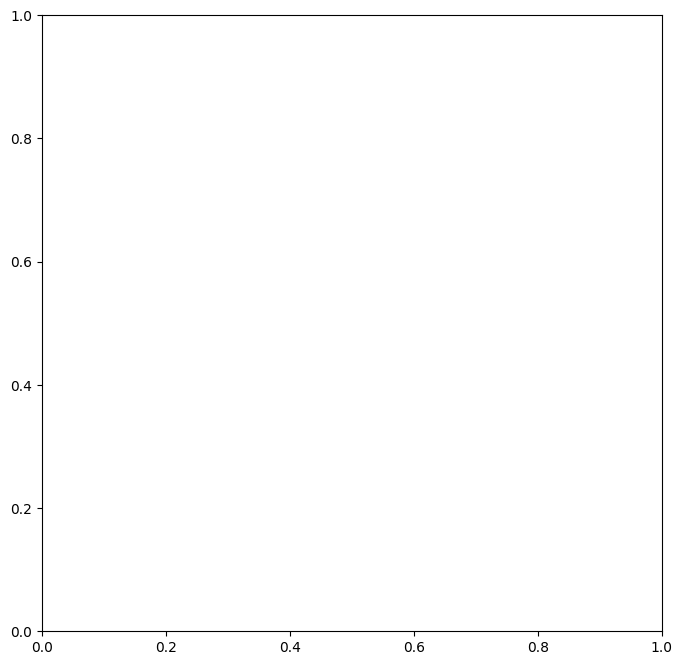

In [25]:
colorbar_kwargs = {
    'aspect': 10,
    'pad': 0.01,
    'shrink': 0.75, 
}

##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, (Hilast[-1]-Hi[0])/(Hi[0]).where(mask_ocean), cmap=cmo.balance, vmin=-1, vmax= 0)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Ice Thickness Change [m]", fontsize= ctfs) 
ax.set_title('Relative thickness change', fontsize= tfs)

ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

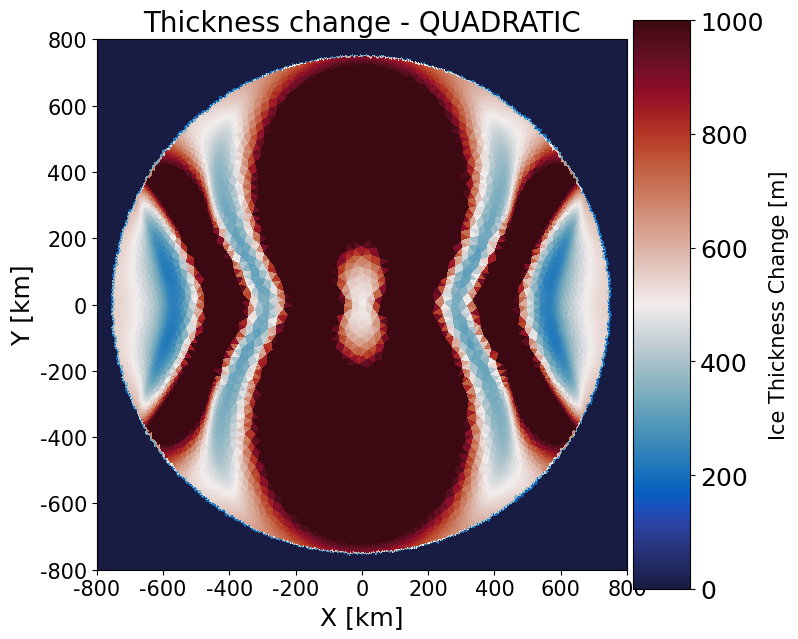

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 

c0 = ax.tripcolor(triang, Hi[0], cmap=cmo.balance, vmin=0, vmax= 1000)
cbar = fig.colorbar(c0, ax=ax, **colorbar_kwargs)
cbar.set_label("Ice Thickness Change [m]", fontsize= ctfs)  # Set fontsize here
cbar.ax.tick_params(labelsize=cbfs)
ax.set_title('Thickness change - QUADRATIC', fontsize=tfs)
#ax.plot([-150000, -150000], [0, 740000], color='black', linestyle='-', linewidth=2)

#ax.text(80000, 100000, 'Halbrane A', fontsize=afs, color='black', ha='center', va='center')
ax.set_xlabel('X [km]', fontsize=afs)
ax.set_ylabel('Y [km]', fontsize=afs)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200), fontsize=tifs)
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Velocity


In [25]:
u_s = Lad['u_surf']
v_s = Lad['v_surf']
          
magice = np.sqrt(u_s**2 +v_s**2)
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 1, 
}

m = 20
Tricc = Lad['Tricc']

fig = plt.figure(figsize=(22, 14))  # Slightly reduced figure size
gs = gridspec.GridSpec(3, 3, height_ratios=[1, 0.04, 1], hspace=0.35, wspace=0.3)  # Tighter spacing

# Create subplots
axes = []
for i in range(6):
    if i < 3:
        axes.append(fig.add_subplot(gs[0, i]))  # First row
    else:
        axes.append(fig.add_subplot(gs[2, i-3]))  # Third row

# Create horizontal colorbar axis between rows
cax = fig.add_subplot(gs[1, :])  # Span all columns in middle row

for i, year in enumerate(years):
    ax = axes[i]

    # Main plot with contour lines
    c0 = ax.tripcolor(
        Tricc[0, :], 
        Tricc[1, :], 
        magice[year], 
        cmap='viridis', 
        vmin=0, 
        vmax=400

    )
    # Axis formatting
    ax.set_title(f'Year {year}', fontsize=13, pad=8)  # Reduced padding
    ax.set_xlabel('X [km]', fontsize=11)
    ax.set_ylabel('Y [km]', fontsize=11)
    ax.set_xticks(np.arange(-n, n+1, 200000))
    ax.set_yticks(np.arange(-n, n+1, 200000))
    ax.set_xticklabels(np.arange(-800, 801, 200))  # Direct labels
    ax.set_yticklabels(np.arange(-800, 801, 200))
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_aspect('equal')


    u_s_norm = u_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)
    v_s_norm = v_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)


    ax.quiver(Tricc[0, :][::m],
        Tricc[1, :][::m],
        u_s_norm,
        v_s_norm,
        scale=40,
        width=0.002,
        headwidth=3,
        headlength=4,
        headaxislength=3
    )


# Colorbar formatting
cbar = fig.colorbar(c0, cax=cax, orientation='horizontal')
cbar.set_label('Velocity [m/s]', fontsize=12, labelpad=10)
cbar.set_ticks(np.linspace(0, 400, 11))  # Add evenly spaced ticks
cax.xaxis.set_ticks_position('bottom')
cax.xaxis.set_label_position('top')

# Main title with adjusted position
plt.suptitle('LADDIE velocity Evolution (Years 0-50) with normalized arrows', 
            fontsize=16, y=0.92)  # More compact title
plt.tight_layout(pad=1.5)  # Reduced padding
plt.show()


NameError: name 'Lad' is not defined

In [26]:
Tricc = Lad['Tricc']
u_s = Lad['u_surf']
v_s = Lad['v_surf']
          
magice = np.sqrt(u_s**2 +v_s**2)
colorbar_kwargs = {
    'aspect': 20,
    'pad': 0.01,
    'shrink': 1, 
}
u = 50
m = 10



##############################################################################################################################
fig, ax = plt.subplots(1, 1, figsize=(16, 8)) 

c0 = ax.tripcolor(
    Tricc[0, :], 
    Tricc[1, :], 
    magice[u], 
    cmap='viridis', 
    vmin=0, 
    vmax=400

)

fig.colorbar(c0, ax=ax, label="Velocity magnitude [m/y]", **colorbar_kwargs)
ax.set_title('Ice velocity', fontsize=14)


u_s_norm = u_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)
v_s_norm = v_s[u][::m] / np.sqrt(u_s[u][::m]**2 + v_s[u][::m]**2)


plt.quiver(Tricc[0, :][::m],
    Tricc[1, :][::m],
    u_s_norm,
    v_s_norm,
    scale=50,
    width=0.002,
    headwidth=3,
    headlength=4,
    headaxislength=3
)

plt.quiverkey(
    plt.quiver(0, 0, 0, 0, scale=10000, width=0.002),
    X=0.75,
    Y=0.97,
    U= 200,
    label=' Normalized quivers',
    labelpos='E',
    coordinates='figure',
    color='k'
)

ax.set_aspect('equal')
ax.set_xlabel('X [km]', fontsize=12)
ax.set_ylabel('Y [km]', fontsize=12)
ax.set_xticks(np.arange(-n, n + 1, 200000))
ax.set_xticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_yticks(np.arange(-n, n + 1, 200000))
ax.set_yticklabels(np.arange(-n // 1000, n // 1000 + 1, 200))
ax.set_xlim(-n, n)
ax.set_ylim(-n, n)

plt.tight_layout()
plt.show()

NameError: name 'Lad' is not defined

In [27]:
plt.close('all')